# Tuning of Hyperparameters in Simple Self-EFficacy Learner Model

This notebook includes code from iterating on the Self-Efficacy Learner Behavior Model including hyperparameters for generating the set of learners in the population.

In [1]:
import sys
sys.path.append("../")

In [77]:
import logging
import random
import uuid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)


In [3]:
from tutor.domain import Domain
from tutor.curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest
from learner.selfeff_learner import SelfEfficacyLearner
from simulate.simple_tutor_simulation import SimpleTutorSimulation
from simulate.simulation import Simulation
from simulate.self_eff_simulation import SelfEffSimulation
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper

In [4]:
#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

In [5]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.debug("Base directory for the project:\n%s" % base_dir)

In [6]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:main:Writing simulation results to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f054265e-e8b7-40f7-9d34-c9a0c82e8868
INFO:main:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [7]:
logger.info("Clearing database before starting new simulation")
db_util.clear_db()

INFO:main:Clearing database before starting new simulation


## Generating Learners

### Setting up Simulation

In [8]:
# Generating domain
domain = Simulation.gen_domain(750)
db.domains.insert_one(domain.to_dict())
db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])

INFO:simulate.simulation:Generating a new domain


In [9]:
# Generating the Curriculum
curric = Simulation.gen_curriculum(domain, 5, 5, 30)
curric_util = DB_Curriculum_Mapper(db_params)
curric_util.write_to_db(curric)

INFO:simulate.simulation:Generating Curriculum with given domain
INFO:log_db.curriculum_mapper:Writing curriculum with id, 66ab0297-c66d-4b03-9982-03698a100929, to db
INFO:log_db.curriculum_mapper:Writing 90000 problem to db
INFO:log_db.curriculum_mapper:Writing 90000 steps to db


### Initializing Learners

In [10]:
num_students = 20
students = [SelfEfficacyLearner(domain) for i in range(num_students)]
logger.info("Sample student:\n%s" % str(students[0]))
logger.info("Inserting %i students to db" % len(students))
result = db.students.insert_many([stu.to_dict() for stu in students])
logger.info("Db insert success: %s" % result.acknowledged)

INFO:main:Sample student:
INFO:main:Inserting 20 students to db
INFO:main:Db insert success: True


### Simulating Learners

In [11]:
for i, stu in enumerate(students):
    logger.info("Simulating student #%i" % i)
    sim = SelfEffSimulation(domain, curric, stu)
    sim.run()

INFO:main:Simulating student #0
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:session start: {'_id': <pymongo.results.InsertOneResult object at 0x1267a5fc0>, 'type': 'Session Start', 'time': datetime.datetime(2020, 9, 23, 11, 21, 7, 321954)}
INFO:tutor.tutor:User Transaction: {'_id': UUID('cc3fe9e5-b584-44c7-b87e-091a74b600fb'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 11, 32, 54, 104551), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('1c025a81-ece7-4439-8c25-a9340357a735'), 'step_id': UUID('6e734157-6a24-4074-bfd9-97168a9df368'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 13.909215203437904, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('b58e7564-91bc-42b2-8521-add565324827'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2570

INFO:tutor.tutor:User Transaction: {'_id': UUID('55f68cdb-c587-42ab-a507-9ac81057d34f'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 12, 11, 53, 770230), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('d44fc4b8-63ec-40d8-9b54-ecae899fd720'), 'step_id': UUID('638adabb-0c47-45f1-928f-254a9306b705'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.00700518328679, 'outcome': 'Correct', 'kcs': [{'_id': UUID('ada02ccb-74f3-4fe3-9075-da588e3b979a'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.22598190839182797, 'pt': 0.02343423636258636, 'ps': 0.38435172260456907, 'pg': 0.23326694002129805, 'm_time': 15.451897110843166, 'sd_time': 3.8629742777107916}], 'plt': 0.14811217513281838, 'plt1': 0.33060035137766325, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transact

INFO:tutor.tutor:User Transaction: {'_id': UUID('8d6e5247-6375-4bad-97f2-20c104de8877'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 12, 16, 32, 378087), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('4ffbe746-398f-48e2-807f-4615ccc6ed26'), 'step_id': UUID('d619bfcd-c0ba-4504-92d3-c105e323ba4e'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 8.240795272263666, 'outcome': 'Correct', 'kcs': [{'_id': UUID('b58e7564-91bc-42b2-8521-add565324827'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2570989433183302, 'pt': 0.0561376700411756, 'ps': 0.41709793235600146, 'pg': 0.2017837309659688, 'm_time': 15.800146901042933, 'sd_time': 3.950036725260733}], 'plt': 0.20068349669993862, 'plt1': 0.4529204462109714, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('a3836842-59b4-4ece-8055-9d5d1a24095d'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 12, 29, 14, 362685), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('686bbeb9-6cbb-497f-9b45-f79fe60bfa5b'), 'step_id': UUID('040e8c9a-8fa8-425d-9e1e-b6017144c815'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 12.880587745796014, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('5cfd3015-36d3-4762-91f0-14f435b49035'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2409443482385457, 'pt': 0.12909229716046733, 'ps': 0.38407813530051976, 'pg': 0.20577785907670976, 'm_time': 14.408997456479046, 'sd_time': 3.6022493641197615}], 'plt': 0.8150538140386809, 'plt1': 0.7218588738038425, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transact

INFO:tutor.tutor:User Transaction: {'_id': UUID('6e4a7ad4-2bd9-4edb-be99-e62fb6035677'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 12, 31, 23, 271441), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('74a4e141-3873-4202-9883-f44bdef382a6'), 'step_id': UUID('aa6faf87-b439-44c5-8576-c5a3fda3dfe0'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 9.658823940858698, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('8fa25a96-71ce-4f84-90d6-ac59fb4d2a76'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2158240763864468, 'pt': -0.009924420272682921, 'ps': 0.3714061177903767, 'pg': 0.1791121743999629, 'm_time': 8.674189001739771, 'sd_time': 2.168547250434943}], 'plt': 0.10190908291836515, 'plt1': 0.039393348176858745, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transact

INFO:tutor.tutor:User Transaction: {'_id': UUID('1c036ee0-a84e-4ebd-82d4-03f0448639ed'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 12, 33, 47, 559738), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('a1860d50-740c-4b49-b0fb-49af1feeec2a'), 'step_id': UUID('3ceb9264-53ef-487c-9642-2ad331690d70'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 10.090909272400063, 'outcome': 'Correct', 'kcs': [{'_id': UUID('8fa25a96-71ce-4f84-90d6-ac59fb4d2a76'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2158240763864468, 'pt': -0.009924420272682921, 'ps': 0.3714061177903767, 'pg': 0.1791121743999629, 'm_time': 8.674189001739771, 'sd_time': 2.168547250434943}], 'plt': 0.039393348176858745, 'plt1': 0.11713750115629529, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transacti

INFO:tutor.tutor:User Transaction: {'_id': UUID('b0d4e244-6c3f-4cd9-b4b6-d39bffef5a7a'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 13, 30, 44, 135753), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('d78558cc-5a0c-4c1d-aa36-358f0406e6a4'), 'step_id': UUID('9e649b00-e436-4bcd-8e91-5dbd537d3650'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.99792395690488, 'outcome': 'Correct', 'kcs': [{'_id': UUID('95b7859d-6526-4a6c-a9a0-c1f71d2dcffe'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2837347594761891, 'pt': 0.0012424353548604605, 'ps': 0.3792793997704652, 'pg': 0.23951601575803955, 'm_time': 16.55465174678741, 'sd_time': 4.138662936696853}], 'plt': 0.33999463265736085, 'plt1': 0.5722693425892805, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('0c6cba02-db1c-4f2a-8608-37c6e074583c'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 13, 33, 16, 129117), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('2c59d460-590e-4f3b-88df-58922182683c'), 'step_id': UUID('5f42333d-9761-4d9b-8931-dc311fc330df'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 21.744699594747463, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('180a9e0d-1d63-4e1e-a0f8-5e1726955fb8'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.1650675814412756, 'pt': 0.05982938711630473, 'ps': 0.34014617427347776, 'pg': 0.1519689834009575, 'm_time': 14.490306428788541, 'sd_time': 3.6225766071971353}], 'plt': 0.3936091256735401, 'plt1': 0.2540431710724364, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transacti

INFO:tutor.tutor:User Transaction: {'_id': UUID('2c44b187-c54e-46f1-b199-85d86b8ad507'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 13, 37, 57, 797143), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('acbe0d12-f32c-4b00-b386-fa9b26e3121d'), 'step_id': UUID('51ba78ba-7f14-41cf-ad60-d63fd4fcd340'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 26.80169724300187, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('69602a83-5fe0-4d27-b333-840b4ce9000b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.20300704176946835, 'pt': 0.06460927839330668, 'ps': 0.2784257411666471, 'pg': 0.18601088300569665, 'm_time': 19.99864909644118, 'sd_time': 4.999662274110295}], 'plt': 0.13957463467042128, 'plt1': 0.11378204305777456, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transacti

INFO:tutor.tutor:User Transaction: {'_id': UUID('5ec757e5-07ef-490c-aa79-976b378dab09'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 13, 41, 4, 839894), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('ac345ebf-15d9-4162-aff9-692a3cf18d5d'), 'step_id': UUID('3937ded9-fb40-40e9-a6aa-e1d0803c38a8'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 9.911106178405882, 'outcome': 'Correct', 'kcs': [{'_id': UUID('01c4840c-b9b9-422f-a7a6-e818686f974a'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.1767773720012567, 'pt': 0.054892009559848354, 'ps': 0.3440954595801924, 'pg': 0.17921859525736525, 'm_time': 9.579987916121691, 'sd_time': 2.394996979030423}], 'plt': 0.13294795264631665, 'plt1': 0.39461538662955653, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('451a21cd-2ef7-48b6-9ebd-a67b5f24d25c'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 13, 42, 50, 892920), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('08868d65-4f44-41b1-9c37-27b5f930b197'), 'step_id': UUID('b975bf6a-86ed-49c5-bcd1-2ad03f0c4b53'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 12.088061144555704, 'outcome': 'Hint', 'kcs': [{'_id': UUID('08f84b9e-4781-4de6-b53a-b1da9d698a4b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.33353358625358476, 'pt': 0.0951073155197714, 'ps': 0.3634238622884276, 'pg': 0.2322186982279124, 'm_time': 11.766747523241097, 'sd_time': 2.9416868808102743}], 'plt': 0.9386553670537165, 'plt1': 0.8902200107397021, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('030046ef-cde8-40a2-8c33-0fc769862918'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 13, 45, 17, 41776), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('d9320f14-6313-4952-a083-6e4277bf7275'), 'step_id': UUID('52ad68dc-2f3f-4361-9273-fdbada437afb'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.139784874838194, 'outcome': 'Correct', 'kcs': [{'_id': UUID('5e9c676c-3bb3-4ef8-a33d-159595bc0624'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.212728112443924, 'pt': 0.01413093286356061, 'ps': 0.36561645607909304, 'pg': 0.21129824938269623, 'm_time': 10.167190416354032, 'sd_time': 2.541797604088508}], 'plt': 0.10669863858190035, 'plt1': 0.2743521945543728, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('0efd33e8-d4ff-4ff3-9703-777f45ea9fae'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 14, 25, 7, 888138), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('3b709252-e84c-4602-bbf9-1bdf9e630ad9'), 'step_id': UUID('7af8ec7f-b59d-4129-833d-07c5a6a9853e'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.776204561621434, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('e0d7581b-919e-4e48-a2a3-08dbf357d825'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2745973902822339, 'pt': 0.08390016897277612, 'ps': 0.3303068865513069, 'pg': 0.17417163385753584, 'm_time': 18.435057346745914, 'sd_time': 4.608764336686479}], 'plt': 0.386831432867967, 'plt1': 0.26848395898815147, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('5ce184ef-f574-40b7-9333-512888dfc001'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 14, 27, 44, 195141), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('6f78065d-fccb-4036-b207-c3738c785c18'), 'step_id': UUID('86fb93af-fc53-4e93-8bd9-3620c0aba658'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 17.086654613784994, 'outcome': 'Correct', 'kcs': [{'_id': UUID('4bdde3bc-ba27-4ab6-87d5-57480d5cccbd'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2897100476841708, 'pt': 0.03402176854984528, 'ps': 0.3277785146863301, 'pg': 0.21831317989004617, 'm_time': 14.094831155328043, 'sd_time': 3.5237077888320107}], 'plt': 0.8664162217628135, 'plt1': 0.9539379792906106, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('b5c4eccf-de1e-4a39-b279-294bf1258e4d'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 14, 46, 0, 921651), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('67202f9f-d577-4f1c-84c0-ed8f03ea879b'), 'step_id': UUID('11916cac-fb01-4578-b134-2ce484f93c26'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 15.283093044716315, 'outcome': 'Correct', 'kcs': [{'_id': UUID('435830b9-7342-49db-a737-e57d178b6c42'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.27824706949801775, 'pt': 0.10048194164443201, 'ps': 0.31578137269331924, 'pg': 0.23587116972601505, 'm_time': 12.930763031165892, 'sd_time': 3.232690757791473}], 'plt': 0.22409651350402943, 'plt1': 0.5105499075071955, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('d1a063cb-e1cb-4a99-b78f-f7dc4f7521d1'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 15, 6, 30, 327841), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('669003e0-c165-46bf-a182-ae892c7a7985'), 'step_id': UUID('72533148-7837-4f5e-a41a-039d32c59037'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 21.022428636660592, 'outcome': 'Correct', 'kcs': [{'_id': UUID('b58e7564-91bc-42b2-8521-add565324827'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2570989433183302, 'pt': 0.0561376700411756, 'ps': 0.41709793235600146, 'pg': 0.2017837309659688, 'm_time': 15.800146901042933, 'sd_time': 3.950036725260733}], 'plt': 0.45295570069689833, 'plt1': 0.7217303436480795, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('09863520-1678-4d60-b73e-ca03bddc98a1'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 15, 8, 8, 682920), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('f8536f20-b560-4234-acb4-51d850b30991'), 'step_id': UUID('b84d1f2d-b6d5-43aa-aae1-34a742b655d5'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.182825853762806, 'outcome': 'Correct', 'kcs': [{'_id': UUID('69602a83-5fe0-4d27-b333-840b4ce9000b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.20300704176946835, 'pt': 0.06460927839330668, 'ps': 0.2784257411666471, 'pg': 0.18601088300569665, 'm_time': 19.99864909644118, 'sd_time': 4.999662274110295}], 'plt': 0.11378204305777456, 'plt1': 0.37559585182742294, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('78b32140-fcc3-42fd-b589-fa2cc703b6b6'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 15, 33, 16, 623707), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('21595556-ed4b-40b4-bd21-6cf9180ff24a'), 'step_id': UUID('fe1fa4ff-255d-48f1-8c8a-743aa2bf0f5a'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.304494147735086, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('0187025f-067c-4d2c-920d-16d00f5140ec'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.38144493133794377, 'pt': 0.049586757353377794, 'ps': 0.3374732285285066, 'pg': 0.23040809342518304, 'm_time': 12.18769954712875, 'sd_time': 3.0469248867821874}], 'plt': 0.45147458506650023, 'plt1': 0.30164104684554305, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transa

INFO:tutor.tutor:User Transaction: {'_id': UUID('983ac7ca-1168-4f50-9183-a1a055c1dec9'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 15, 34, 56, 81587), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('659dff8c-ab63-4779-a6a7-0b44585d556b'), 'step_id': UUID('3e22dd40-1a9f-41f0-bf44-552a500792a6'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 8.13261270107421, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('8fa25a96-71ce-4f84-90d6-ac59fb4d2a76'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2158240763864468, 'pt': -0.009924420272682921, 'ps': 0.3714061177903767, 'pg': 0.1791121743999629, 'm_time': 8.674189001739771, 'sd_time': 2.168547250434943}], 'plt': 0.3970478626433744, 'plt1': 0.22190061474783565, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('d6fc5fbb-63b5-4595-acca-13594ebd9f53'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 15, 37, 35, 874379), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('ab4001dc-9906-4097-92b1-1ba98e7a266c'), 'step_id': UUID('2a28d931-dd0b-4b3a-8ce1-e667d91b1119'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 17.516181238932617, 'outcome': 'Correct', 'kcs': [{'_id': UUID('69602a83-5fe0-4d27-b333-840b4ce9000b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.20300704176946835, 'pt': 0.06460927839330668, 'ps': 0.2784257411666471, 'pg': 0.18601088300569665, 'm_time': 19.99864909644118, 'sd_time': 4.999662274110295}], 'plt': 0.22422680081458204, 'plt1': 0.5590341898903699, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('a1e8ce8d-fe58-4062-ade7-dd909caaa795'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 15, 45, 42, 755923), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('5c7e18ba-63d2-4f6f-844b-317516eb4295'), 'step_id': UUID('e750028d-f7bb-4ffd-8e39-6a5b53c6e0c6'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 10.45441693182369, 'outcome': 'Hint', 'kcs': [{'_id': UUID('180a9e0d-1d63-4e1e-a0f8-5e1726955fb8'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.1650675814412756, 'pt': 0.05982938711630473, 'ps': 0.34014617427347776, 'pg': 0.1519689834009575, 'm_time': 14.490306428788541, 'sd_time': 3.6225766071971353}], 'plt': 0.6207035267763219, 'plt1': 0.43239640198341983, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('5f9cef31-4e0b-4ffa-9bd4-7e16c42afd5d'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 15, 50, 36, 178743), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('2de2109a-aefa-4401-8730-4c0fb525c993'), 'step_id': UUID('2155bec0-94a8-4aba-ad38-69072c8cb5bb'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 20.18030708297417, 'outcome': 'Hint', 'kcs': [{'_id': UUID('e0d7581b-919e-4e48-a2a3-08dbf357d825'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2745973902822339, 'pt': 0.08390016897277612, 'ps': 0.3303068865513069, 'pg': 0.17417163385753584, 'm_time': 18.435057346745914, 'sd_time': 4.608764336686479}], 'plt': 0.44571810829739833, 'plt1': 0.30684126066534073, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('99e88d90-ace1-4488-ba48-1f16291fd40a'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 15, 52, 15, 728784), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('a91ec3fd-0cea-4b0f-9c03-e7acf2bce87b'), 'step_id': UUID('e3c7db78-562b-47ab-84ae-1e00e4d8cdee'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 6.6994543604528864, 'outcome': 'Correct', 'kcs': [{'_id': UUID('8fa25a96-71ce-4f84-90d6-ac59fb4d2a76'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2158240763864468, 'pt': -0.009924420272682921, 'ps': 0.3714061177903767, 'pg': 0.1791121743999629, 'm_time': 8.674189001739771, 'sd_time': 2.168547250434943}], 'plt': 0.4952520073127153, 'plt1': 0.772717329412849, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('1c4560b4-36ef-4d5d-8158-08d5fbbf7032'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 15, 54, 35, 26446), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('f4c227e9-dea5-4c80-8db2-ae5c45a6df7c'), 'prob_id': UUID('300bc5de-d1f4-4970-9255-9510a891f9c8'), 'step_id': UUID('f2bc196c-d496-47cd-b67c-804009a0aed2'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.657232388329172, 'outcome': 'Correct', 'kcs': [{'_id': UUID('a82d10ee-74e7-43ad-bcd9-d6cdf63dc970'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.40011982414903957, 'pt': 0.049933321322847765, 'ps': 0.33608963827309135, 'pg': 0.1941120900444152, 'm_time': 17.406337636006047, 'sd_time': 4.351584409001512}], 'plt': 0.4655520529749441, 'plt1': 0.7612500338621837, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('ea898646-eb3e-4195-9c77-63d319e0d2e3'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 16, 38, 29, 316392), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('109b579c-956c-47c3-8411-ccc30ed5e4a2'), 'step_id': UUID('aa0d76ba-ea2c-49f7-9681-9b470e086ad6'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 3.6014199202077535, 'outcome': 'Hint', 'kcs': [{'_id': UUID('a6379c24-4a33-4fb7-80f5-2174c2ec064e'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.23039017228654946, 'pt': 0.046517206451084224, 'ps': 0.3527335178004649, 'pg': 0.1990827428259762, 'm_time': 15.257759203554011, 'sd_time': 3.8144398008885028}], 'plt': 0.23039017228654946, 'plt1': 0.15758282404060314, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('a02cf717-b14c-42e9-912c-3885ba497436'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 16, 40, 32, 478664), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('14532a51-3625-44b9-81c0-3af2a7c8afb8'), 'step_id': UUID('23fb9672-86d6-4d22-a2e5-f1064b3eb6a1'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 10.596376427877331, 'outcome': 'Correct', 'kcs': [{'_id': UUID('1f408269-9760-4277-abf3-d0f0e70faee7'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.200076503640114, 'pt': 0.05081808519562697, 'ps': 0.35723805506015316, 'pg': 0.2470731506628355, 'm_time': 10.257488976767382, 'sd_time': 2.5643722441918455}], 'plt': 0.1515109733381106, 'plt1': 0.3518904443749668, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('f8b640a4-3b6f-4314-a46a-0301faea52ad'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 16, 42, 31, 414614), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('4331f0ae-49d9-4ccf-8e77-0f5880c58bb3'), 'step_id': UUID('93b29cca-5467-4573-9250-ef3776464738'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 8.677129227068324, 'outcome': 'Hint', 'kcs': [{'_id': UUID('f4445d65-3971-4273-b04b-3a1b87459aa3'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3210399456950783, 'pt': 0.057423586939339674, 'ps': 0.31734080159903716, 'pg': 0.18342377109753236, 'm_time': 6.715289646041123, 'sd_time': 1.6788224115102808}], 'plt': 0.3210399456950783, 'plt1': 0.2037416747241589, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('fed714f5-4b14-4439-b096-e641ebf509eb'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 16, 44, 59, 320197), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('c3c830db-14da-4d1d-b3b7-3402a21bf60e'), 'step_id': UUID('41baee0e-25c7-447c-8c77-63c339da3c02'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 6.374531780348198, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('02debff8-0b3c-42b7-81da-af10b479e83b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.37447064065396984, 'pt': 0.12102331748799022, 'ps': 0.3630596807758055, 'pg': 0.14840898580101436, 'm_time': 9.00794408784692, 'sd_time': 2.25198602196173}], 'plt': 0.37447064065396984, 'plt1': 0.29974368891496855, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('11bb2783-0d1b-401d-9de2-b5ffb021f2fc'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 16, 46, 52, 375013), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('bbe83b8c-6b40-445a-9609-ffe4d1c07e32'), 'step_id': UUID('710edabe-f931-42b2-a595-1586dddc5339'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 9.94499049505924, 'outcome': 'Correct', 'kcs': [{'_id': UUID('02debff8-0b3c-42b7-81da-af10b479e83b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.37447064065396984, 'pt': 0.12102331748799022, 'ps': 0.3630596807758055, 'pg': 0.14840898580101436, 'm_time': 9.00794408784692, 'sd_time': 2.25198602196173}], 'plt': 0.29974368891496855, 'plt1': 0.6901842361608561, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('280b5a71-4462-4722-9892-909cb0fea6cf'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 17, 3, 32, 735447), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('d2894ebc-63f0-4455-b456-2a99abb353e2'), 'step_id': UUID('dc5b6781-cb94-4b19-90f3-379f16381e92'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.59719540326301, 'outcome': 'Hint', 'kcs': [{'_id': UUID('70cb214f-a449-43c8-bf24-42b359798ec3'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.15527265671519852, 'pt': 0.049677814982465845, 'ps': 0.32454339159370105, 'pg': 0.2057474408639423, 'm_time': 14.440752078048328, 'sd_time': 3.610188019512082}], 'plt': 0.33594209342075576, 'plt1': 0.21247191787947023, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('8918034b-d932-479e-99e3-74b8a61b5dfa'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 17, 17, 46, 278490), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('812e50e8-7bf0-47bf-837f-a3cced0bfb4c'), 'step_id': UUID('26b429a0-6a84-48f9-b23b-1fd4ca268592'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 3.7230391636915434, 'outcome': 'Hint', 'kcs': [{'_id': UUID('f4445d65-3971-4273-b04b-3a1b87459aa3'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3210399456950783, 'pt': 0.057423586939339674, 'ps': 0.31734080159903716, 'pg': 0.18342377109753236, 'm_time': 6.715289646041123, 'sd_time': 1.6788224115102808}], 'plt': 0.2037416747241589, 'plt1': 0.14267481586700967, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('bcee9d04-adcf-4dd2-bf61-b12c391ffe2d'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 17, 41, 17, 29665), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('15b4128d-295e-4956-aee5-99a294e4911f'), 'step_id': UUID('ac9d8409-0008-4323-bd5b-c46492fb84ef'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 7.077342597101564, 'outcome': 'Hint', 'kcs': [{'_id': UUID('02debff8-0b3c-42b7-81da-af10b479e83b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.37447064065396984, 'pt': 0.12102331748799022, 'ps': 0.3630596807758055, 'pg': 0.14840898580101436, 'm_time': 9.00794408784692, 'sd_time': 2.25198602196173}], 'plt': 0.6901842361608561, 'plt1': 0.5491845121057254, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_id'

INFO:tutor.tutor:User Transaction: {'_id': UUID('0001483d-f84c-4bba-8e70-f911b3dd4068'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 2, 46, 226018), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('5277b9d1-e341-47c7-9265-a6ba158d576d'), 'step_id': UUID('9622e67a-0c77-47fa-86b4-de4fe1990536'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.588362012941767, 'outcome': 'Hint', 'kcs': [{'_id': UUID('f262c950-b37b-4c10-9a67-d01fa88fd112'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3661832974307536, 'pt': 0.04836607447908085, 'ps': 0.3234969533060712, 'pg': 0.2293841228482904, 'm_time': 13.188653905743262, 'sd_time': 3.2971634764358155}], 'plt': 0.23411649642461776, 'plt1': 0.15659375601042544, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('471be972-035b-4ef9-8b7c-87f0128c4511'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 5, 56, 667081), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('8430a47b-4f00-4f92-a838-0e313f1b7901'), 'step_id': UUID('a3342624-8694-4780-8253-1f0d75658df5'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 22.852288335697004, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('232e4bf6-5ac0-443a-9769-76abcb2fa1af'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.22009723637281953, 'pt': 0.030355635925229905, 'ps': 0.33576067071621435, 'pg': 0.22202286880023542, 'm_time': 21.035665434848987, 'sd_time': 5.258916358712247}], 'plt': 0.1356330644452599, 'plt1': 0.09185698842632806, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transac

INFO:tutor.tutor:User Transaction: {'_id': UUID('4b217b57-d51c-4d78-b502-ebf4067e78c7'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 7, 53, 338952), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('800a3048-ca0b-4629-9e05-1adf7e7e76a8'), 'step_id': UUID('75aebbfa-3162-4395-9f9c-6f47660bf1d4'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 7.9257784446370145, 'outcome': 'Correct', 'kcs': [{'_id': UUID('f4445d65-3971-4273-b04b-3a1b87459aa3'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3210399456950783, 'pt': 0.057423586939339674, 'ps': 0.31734080159903716, 'pg': 0.18342377109753236, 'm_time': 6.715289646041123, 'sd_time': 1.6788224115102808}], 'plt': 0.4179362995521007, 'plt1': 0.7433292055202607, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('1f8919ff-62a8-4dd7-9466-59e37661d19f'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 9, 20, 617610), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('cb9dd780-724f-41b9-8062-2cb88422f5ba'), 'step_id': UUID('49e813ef-d689-4db9-9254-93b6286478a5'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 7.456385734373034, 'outcome': 'Hint', 'kcs': [{'_id': UUID('7737a07a-4d21-4391-ae9c-ed402605cc67'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.4171429172652298, 'pt': 0.06489327494627564, 'ps': 0.38466548708830045, 'pg': 0.17356906134884564, 'm_time': 8.349768599502568, 'sd_time': 2.087442149875642}], 'plt': 0.21951679088479903, 'plt1': 0.1731395709121224, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('a5624277-3d6b-4f1a-aee6-cc7fe84a4d1e'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 11, 7, 744559), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('4495bfe5-fb03-4b48-9ed1-eccaf38ec7c6'), 'step_id': UUID('38ea322e-69fa-4476-933d-99ef53b39038'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 11.599987752326706, 'outcome': 'Correct', 'kcs': [{'_id': UUID('02debff8-0b3c-42b7-81da-af10b479e83b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.37447064065396984, 'pt': 0.12102331748799022, 'ps': 0.3630596807758055, 'pg': 0.14840898580101436, 'm_time': 9.00794408784692, 'sd_time': 2.25198602196173}], 'plt': 0.7870074620093936, 'plt1': 0.9478604852346978, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('84fdc9b1-8dd2-480e-8073-3b2e85cc5048'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 26, 46, 238058), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('f88383dd-2f0f-4e34-828a-1a72aca01f87'), 'step_id': UUID('b04e5535-0a67-43ba-86fa-435d3ced3e9b'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 11.214540788597617, 'outcome': 'Correct', 'kcs': [{'_id': UUID('f262c950-b37b-4c10-9a67-d01fa88fd112'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3661832974307536, 'pt': 0.04836607447908085, 'ps': 0.3234969533060712, 'pg': 0.2293841228482904, 'm_time': 13.188653905743262, 'sd_time': 3.2971634764358155}], 'plt': 0.15659375601042544, 'plt1': 0.3850807877008428, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('7c64c11f-03c8-494a-8602-69e579bcf4d7'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 28, 38, 307997), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('5e80ede3-d574-4537-9136-8fe91f41ef9c'), 'step_id': UUID('7101848c-aae3-4dcf-bb13-7cebcfa0863d'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.662335308937655, 'outcome': 'Correct', 'kcs': [{'_id': UUID('0eb25b12-af93-4f57-8757-27b926702e3e'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3448262411735092, 'pt': 0.11412403364864146, 'ps': 0.2636437197219675, 'pg': 0.21828510153053823, 'm_time': 14.488918677190192, 'sd_time': 3.622229669297548}], 'plt': 0.5699763460707077, 'plt1': 0.8380850978091071, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('a4a6e505-55e1-4688-acba-861e6dddb0cb'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 30, 32, 596600), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('4fb9d359-17cd-4385-af07-887a33c546f7'), 'step_id': UUID('64b542a4-8d3c-4c45-ace3-c3ffec8b75b8'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 7.6877188660483196, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('27aa3c15-8f18-4efd-a952-7a7307a8e2a6'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.22885228268519764, 'pt': 0.03656316159697232, 'ps': 0.35600616410310437, 'pg': 0.15548160872294367, 'm_time': 10.696048325130487, 'sd_time': 2.674012081282622}], 'plt': 0.14368973801701085, 'plt1': 0.10021100424711052, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transa

INFO:tutor.tutor:User Transaction: {'_id': UUID('75b19e57-90f2-48e0-985a-4e00de2d20d3'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 33, 20, 982365), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('6a9ed5a1-3817-4b5d-a0cd-af2ab7cadda1'), 'step_id': UUID('eff01ceb-d757-4a8f-8d2a-be516ac0dbce'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 28.469574037613306, 'outcome': 'Correct', 'kcs': [{'_id': UUID('022a5f59-5319-46b7-8905-9719e82ed52e'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2831904569819153, 'pt': 0.07626702938703003, 'ps': 0.3365623921231692, 'pg': 0.2555927710674229, 'm_time': 20.54516524898552, 'sd_time': 5.13629131224638}], 'plt': 0.4097058035631211, 'plt1': 0.6702821898462361, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('4b4d737e-3b7c-4588-82d7-cbe029e461d5'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 35, 18, 551295), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('c1bf2bd7-2052-46d1-82a4-27bf72ec9778'), 'step_id': UUID('7af69921-6a06-4961-97d8-eac13040091b'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 4.072272923513162, 'outcome': 'Correct', 'kcs': [{'_id': UUID('61f67d97-7d44-4b2f-aa15-b4caa9f66e84'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.4705955112377762, 'pt': 0.05705210563994821, 'ps': 0.33864008660153283, 'pg': 0.19509364582247732, 'm_time': 5.358675263467832, 'sd_time': 1.339668815866958}], 'plt': 0.18960156836180514, 'plt1': 0.4741296251305634, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('2c719eae-f67b-4931-bbf3-76c0647c6d5a'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 18, 37, 52, 457145), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('6a2632d9-4014-4c00-b6fd-dd6f81db82d0'), 'step_id': UUID('43790ea8-731d-4862-a3c1-3873d19cb321'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 17.79194749308637, 'outcome': 'Correct', 'kcs': [{'_id': UUID('0eb25b12-af93-4f57-8757-27b926702e3e'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3448262411735092, 'pt': 0.11412403364864146, 'ps': 0.2636437197219675, 'pg': 0.21828510153053823, 'm_time': 14.488918677190192, 'sd_time': 3.622229669297548}], 'plt': 0.8380850978091071, 'plt1': 0.9520132430057827, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('02b97b93-166c-4f2d-9073-e0476c1fd330'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 19, 26, 45, 909575), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('a22deb00-f6f1-4d85-ab2f-a87c73e565b1'), 'step_id': UUID('5f64bf5c-2312-466f-9b74-035c6516bd3f'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 18.86684132485256, 'outcome': 'Hint', 'kcs': [{'_id': UUID('57e185a7-0d77-4ddc-94d2-33c0f49bd334'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.26040677044280724, 'pt': 0.08266173374401649, 'ps': 0.3419981602103633, 'pg': 0.17291040046787515, 'm_time': 14.389070726969655, 'sd_time': 3.5972676817424136}], 'plt': 0.6644485146209833, 'plt1': 0.4956331085110635, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('8faa325d-0f63-4db0-b281-f594c21e6c5a'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 19, 56, 3, 878494), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('8d966775-3dea-44cf-8697-996fa2968206'), 'step_id': UUID('5b7bb7ca-8ea3-4d68-8d1e-1f7316687592'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 7.790741104383657, 'outcome': 'Correct', 'kcs': [{'_id': UUID('0f5cda96-c246-4289-95cd-41d043d6aeb7'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.12266044124541414, 'pt': 0.13105928283496066, 'ps': 0.367244153298194, 'pg': 0.21788861969713744, 'm_time': 7.197196324278462, 'sd_time': 1.7992990810696154}], 'plt': 0.6391341114318065, 'plt1': 0.8585563479783321, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('e87fec29-91f3-4cb9-b809-6e1ba6f25102'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 20, 6, 59, 752431), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('3a8adb5f-8c8f-4615-a3d7-22604abab888'), 'step_id': UUID('322c7057-1e62-42f4-bfa4-7e6f2a508ac7'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 13.96628316953759, 'outcome': 'Hint', 'kcs': [{'_id': UUID('f262c950-b37b-4c10-9a67-d01fa88fd112'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3661832974307536, 'pt': 0.04836607447908085, 'ps': 0.3234969533060712, 'pg': 0.2293841228482904, 'm_time': 13.188653905743262, 'sd_time': 3.2971634764358155}], 'plt': 0.1632522864107803, 'plt1': 0.12040691738952938, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('47f209f8-aa4b-4198-bc66-94ece46646f5'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 20, 8, 42, 457579), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('4fde09d0-320e-4da2-b2b3-d4ae1fa7e619'), 'step_id': UUID('01f3d22e-0048-4b4c-abab-32517e2024e9'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 10.135284940936465, 'outcome': 'Hint', 'kcs': [{'_id': UUID('199c4928-ddd2-4775-90a8-7e5962e80ca4'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.139221602725401, 'pt': 0.12014630617374839, 'ps': 0.31980958562315315, 'pg': 0.20090906508732764, 'm_time': 13.84415882441214, 'sd_time': 3.461039706103035}], 'plt': 0.46442108968473933, 'plt1': 0.3468260039598275, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('4c82c852-d9cb-4972-b4aa-8d20c7ae7615'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 20, 11, 2, 19098), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('9ba3be95-4020-4169-b865-6b24c2f2055f'), 'prob_id': UUID('cf6d66bf-dbfe-457e-bfa7-e0bc533b38f8'), 'step_id': UUID('274d7dc1-639d-4d7e-ac2f-76bca3d05814'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 5.947987616485431, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('83bd38e6-17ff-4900-ac4f-ce0413addb63'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.4121250344805452, 'pt': 0.09686775756096558, 'ps': 0.29794455387128166, 'pg': 0.18941786254495774, 'm_time': 7.233637945603892, 'sd_time': 1.808409486400973}], 'plt': 0.49661696673726746, 'plt1': 0.33721294052596773, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('28ecffe4-3eb6-4fe0-830f-9bca659985aa'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 20, 25, 17, 589820), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('07be5507-0270-49a4-a886-6e1ae3999f13'), 'step_id': UUID('7e18be36-80e1-49fc-9740-e71397adf7be'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.9249719679005, 'outcome': 'Correct', 'kcs': [{'_id': UUID('c1bc1832-cebf-4451-b8e7-06e7c20f51bf'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.23389068214951692, 'pt': 0.07725056945216326, 'ps': 0.3698913715212689, 'pg': 0.20380328396121225, 'm_time': 12.716052601660296, 'sd_time': 3.179013150415074}], 'plt': 0.23389068214951692, 'plt1': 0.5253104698470485, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('778d6c1b-c9fd-4da7-aae6-ec25ff4bd60b'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 20, 27, 19, 825975), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('974c40f3-fe9d-45ec-865d-8182e7e4b568'), 'step_id': UUID('a8e530d8-6a73-4819-bdcb-c1fe5c21c7e6'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 17.20004250467525, 'outcome': 'Correct', 'kcs': [{'_id': UUID('b6a524a6-ce49-4ca9-816a-46e48e682c8f'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.21557224080677456, 'pt': 0.10012112731419576, 'ps': 0.3503736022323232, 'pg': 0.22019303520498734, 'm_time': 20.742579064201774, 'sd_time': 5.185644766050443}], 'plt': 0.21557224080677456, 'plt1': 0.5030419430054432, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('70a21760-925d-4383-9f1f-350b2bb33238'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 20, 40, 28, 261726), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('8e150ce5-4981-474a-8477-65ca909a8283'), 'step_id': UUID('5074429a-c704-4398-b90d-909e0a611c88'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 9.666686327088055, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('1b16be0a-72e6-4701-ab59-e44986811272'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2510677676133238, 'pt': 0.07799787539629387, 'ps': 0.3306080260914249, 'pg': 0.24224084116055145, 'm_time': 17.960866966415534, 'sd_time': 4.490216741603883}], 'plt': 0.4486056540580908, 'plt1': 0.3195376815274419, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('81aedeee-d565-43b2-b960-3ef9a2dd7d5c'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 20, 45, 22, 573698), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('521d8f62-975f-4ba7-9e52-8f9c75ab7b05'), 'step_id': UUID('378a86e8-72a1-4eb1-a0c0-046f3e10555f'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 6.27736980524983, 'outcome': 'Hint', 'kcs': [{'_id': UUID('b01e45ee-327d-4327-a2d8-09bedf2773df'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.18271235896609408, 'pt': 0.027764063428766035, 'ps': 0.320252516735301, 'pg': 0.22662526512444836, 'm_time': 6.419601752542425, 'sd_time': 1.6049004381356062}], 'plt': 0.2506439876272315, 'plt1': 0.1460430617331284, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('4b6e67c8-7205-41a9-ac9b-0826838711b6'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 21, 12, 19, 973234), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('c8687d63-e9be-4407-87dd-f27f26de1f31'), 'step_id': UUID('63b547c9-bab2-4f23-b9af-011ee8feb126'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.434936799831057, 'outcome': 'Correct', 'kcs': [{'_id': UUID('9556884b-bdf5-4dad-b83c-69af68bc42ff'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.05609497222265897, 'pt': 0.09531597604208766, 'ps': 0.35458673083954123, 'pg': 0.21548396706677314, 'm_time': 15.516378631575572, 'sd_time': 3.879094657893893}], 'plt': 0.11898071450860234, 'plt1': 0.3558656544935451, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transacti

INFO:tutor.tutor:User Transaction: {'_id': UUID('3cf8f4a9-4894-4cf0-9b49-ad75bd104103'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 21, 14, 12, 692451), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('a0c6db05-91dd-43fd-bc62-057bc3c87633'), 'step_id': UUID('2e70f77c-b8ea-410a-8610-19876696aeda'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 3.2814490954719537, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('23909702-8a89-4f31-bbd0-b4ffe5bea3bb'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.29947964291441914, 'pt': 0.11257677447470651, 'ps': 0.31748881905507254, 'pg': 0.18779548604000829, 'm_time': 2.6939835981521494, 'sd_time': 0.6734958995380373}], 'plt': 0.29947964291441914, 'plt1': 0.23964224840547696, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Trans

INFO:tutor.tutor:User Transaction: {'_id': UUID('3d27b42c-ef7d-4d14-876e-bc6a214af3f0'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 21, 20, 56, 258297), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('135e5436-283d-4a84-8d7b-be1eb3870709'), 'step_id': UUID('efee9bf3-f346-404e-b872-6d9bdcd715c9'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.736046223767257, 'outcome': 'Hint', 'kcs': [{'_id': UUID('cd07ecca-545b-48af-a88e-f954eb0d69b4'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3424403358237564, 'pt': 0.10144220734615642, 'ps': 0.3337326979981214, 'pg': 0.2073026644790807, 'm_time': 18.231763815044353, 'sd_time': 4.557940953761088}], 'plt': 0.8777403990539001, 'plt1': 0.7766202365375705, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('bfc0fb1a-938e-4e0a-a2d0-1f424151f6a7'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 21, 23, 13, 404370), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('85f921b1-48a2-49fd-ad63-df62b0fe7476'), 'step_id': UUID('3b4ec454-0813-4358-97e1-5c998ca35e12'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 18.369452671234633, 'outcome': 'Correct', 'kcs': [{'_id': UUID('9556884b-bdf5-4dad-b83c-69af68bc42ff'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.05609497222265897, 'pt': 0.09531597604208766, 'ps': 0.35458673083954123, 'pg': 0.21548396706677314, 'm_time': 15.516378631575572, 'sd_time': 3.879094657893893}], 'plt': 0.2283314672610318, 'plt1': 0.5203804356879879, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('90ab2e6c-eb38-4212-bfa1-15c5320c3dba'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 21, 25, 5, 869659), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('07a855da-5e44-4d9d-b8a9-4d80df4b27d8'), 'step_id': UUID('11996a6d-e501-44e8-92d7-285a26cee55b'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 9.436782910999936, 'outcome': 'Hint', 'kcs': [{'_id': UUID('fe294f86-2fb7-4c52-9c58-f30a026fe419'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.31404895995061066, 'pt': 0.08912817410490514, 'ps': 0.358517787353948, 'pg': 0.22788870798546332, 'm_time': 13.079297549651818, 'sd_time': 3.2698243874129544}], 'plt': 0.5286309330970167, 'plt1': 0.4010344631826994, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('8f3db807-44d7-47bc-b8b6-65ff610032c6'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 21, 27, 58, 225402), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('9c3094e0-75e3-4cbf-847d-72f8c8982a3a'), 'step_id': UUID('ecfa28c1-cebe-4b5e-91b2-23dcd6a19652'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.742340367294595, 'outcome': 'Hint', 'kcs': [{'_id': UUID('a7b37b50-11e2-46e0-83ae-4e5f481ff327'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2664164656217397, 'pt': 0.06889154059313757, 'ps': 0.34766179966107874, 'pg': 0.23669550556089483, 'm_time': 18.75876017061347, 'sd_time': 4.689690042653368}], 'plt': 0.3218200535981721, 'plt1': 0.23437149976389382, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('dffe5746-2356-4a9f-9f55-d2fa9293a610'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 21, 30, 6, 958883), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('ea73b278-1cd6-4ff0-9711-e27301aea69d'), 'step_id': UUID('715e1c53-0dae-41b5-908a-c3d797c05b53'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 12.836239288997803, 'outcome': 'Hint', 'kcs': [{'_id': UUID('c1b6b4ce-d55f-4eab-a538-c507161326f4'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2953584460789961, 'pt': 0.04871358076052582, 'ps': 0.35101140311819673, 'pg': 0.1653537507601449, 'm_time': 10.766071154191525, 'sd_time': 2.6915177885478814}], 'plt': 0.09444067614322352, 'plt1': 0.0886832287359713, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('46db894f-5c18-4491-906f-e74c7719c2d7'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 22, 6, 7, 283456), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('f110e9c1-0c7b-414c-b824-443d0ea970e5'), 'step_id': UUID('64a6d21e-98fd-4dc3-b1a9-88daa51184b6'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 30.663560769288104, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('52cd8f4b-c25f-4046-8a06-b4a298a19ac3'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.23334349767237747, 'pt': 0.09618246274146167, 'ps': 0.36588954642758664, 'pg': 0.15253660433633418, 'm_time': 20.79578674829882, 'sd_time': 5.198946687074705}], 'plt': 0.2011572986397868, 'plt1': 0.18480884742882703, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('0d2589c2-edc4-4cd6-9541-878ef1fe30ba'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 22, 9, 4, 819699), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('fcb9df0e-654c-482d-b244-7a099206bfcb'), 'step_id': UUID('2e21ee7f-8c94-49e9-9cf2-7535cce78f14'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 28.09726564065171, 'outcome': 'Correct', 'kcs': [{'_id': UUID('7d115806-7a12-4f05-9404-085de0c12ef4'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3481213352583285, 'pt': 0.04294734419992178, 'ps': 0.36232607027062114, 'pg': 0.2508493762947741, 'm_time': 25.90406687091985, 'sd_time': 6.476016717729962}], 'plt': 0.3697004847982551, 'plt1': 0.6158016483990498, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('a3445a24-66fb-4fc2-9f04-635c584613a4'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 22, 11, 43, 355713), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('3e73062b-7221-4c80-b395-9667da46323d'), 'step_id': UUID('c7200b71-3468-4c2b-b4ab-b84eb307bb81'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 6.075071570284965, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('c1bc1832-cebf-4451-b8e7-06e7c20f51bf'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.23389068214951692, 'pt': 0.07725056945216326, 'ps': 0.3698913715212689, 'pg': 0.20380328396121225, 'm_time': 12.716052601660296, 'sd_time': 3.179013150415074}], 'plt': 0.3905684385853875, 'plt1': 0.2889524315117357, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('f3aa2008-dbe9-4799-999c-8ee1767a4ce8'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 22, 46, 56, 264684), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('2bf494c6-dc9c-48c6-b3c3-26ae1e1c87ad'), 'step_id': UUID('0f4e807a-08d0-4205-a164-ac9fd4f7bab9'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.104892351442496, 'outcome': 'Hint', 'kcs': [{'_id': UUID('c1bc1832-cebf-4451-b8e7-06e7c20f51bf'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.23389068214951692, 'pt': 0.07725056945216326, 'ps': 0.3698913715212689, 'pg': 0.20380328396121225, 'm_time': 12.716052601660296, 'sd_time': 3.179013150415074}], 'plt': 0.2889524315117357, 'plt1': 0.22379177407248863, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('6e818634-7059-4cc7-a4c1-14721db29a7a'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 23, 8, 42, 705596), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('a23ca4c3-6600-4b22-a5cb-3018316aeb6d'), 'step_id': UUID('6a559e91-0080-46ec-aa5e-e1d4aeb9704d'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 15.377247919904642, 'outcome': 'Correct', 'kcs': [{'_id': UUID('14128efb-10c2-4031-b27f-f08802ffc111'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3262997090225728, 'pt': 0.0567254792667623, 'ps': 0.3567270334029449, 'pg': 0.20939583235022, 'm_time': 17.55664086103419, 'sd_time': 4.389160215258547}], 'plt': 0.7462029567796183, 'plt1': 0.905976112229392, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_id'

INFO:tutor.tutor:User Transaction: {'_id': UUID('e853d87c-517f-43bb-b3ae-a23201781810'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 23, 42, 13, 614079), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('560f48e2-645a-457d-a3d4-156e6e0f4860'), 'step_id': UUID('b5a25944-cda3-4c03-a955-66324ad80709'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 21.685998345456028, 'outcome': 'Correct', 'kcs': [{'_id': UUID('869ea0a9-ded2-4271-b798-5673c8235f86'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.4012282049907726, 'pt': 0.06574382513344534, 'ps': 0.38499168319093513, 'pg': 0.18662926967636645, 'm_time': 15.975676170275804, 'sd_time': 3.993919042568951}], 'plt': 0.21753996456751132, 'plt1': 0.5124367555170771, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('cb2421b6-ece8-44cd-80c6-5e83490eccef'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 23, 44, 58, 948813), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('aca6eed3-3671-4b9a-aaed-4384d34a8cbc'), 'step_id': UUID('9d222c61-2b65-4b0d-b9d0-9f9eb1f97d82'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 18.00043208554605, 'outcome': 'Correct', 'kcs': [{'_id': UUID('b697ce49-f38a-49c1-a616-3114f311839d'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2920040637456441, 'pt': 0.023438697733097508, 'ps': 0.2948678476643918, 'pg': 0.25340664867369606, 'm_time': 16.989632512531106, 'sd_time': 4.2474081281327765}], 'plt': 0.5958497523220883, 'plt1': 0.8086104432435733, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('7ac008f7-4f58-4366-b06d-a51e0167dca2'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 23, 47, 53, 887552), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('50c43dca-9f97-474a-b186-92de50acb5ce'), 'step_id': UUID('d16981a5-c3d1-402e-b786-60fe3848a539'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 27.569654445436203, 'outcome': 'Hint', 'kcs': [{'_id': UUID('b6a524a6-ce49-4ca9-816a-46e48e682c8f'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.21557224080677456, 'pt': 0.10012112731419576, 'ps': 0.3503736022323232, 'pg': 0.22019303520498734, 'm_time': 20.742579064201774, 'sd_time': 5.185644766050443}], 'plt': 0.8589686187175859, 'plt1': 0.7591695008375516, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('fc5c58e3-64d5-4c8b-8b8c-b1dd2bb1d575'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 23, 50, 9, 772104), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('e6fa742e-43b2-4ab5-8067-5d67546d3199'), 'step_id': UUID('1de3ba42-bc8d-41ae-b6e8-468ec317aa70'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 12.946778086498185, 'outcome': 'Hint', 'kcs': [{'_id': UUID('6d9c60f1-02cc-4793-8bca-ee777ac448a3'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.36959636717992217, 'pt': 0.06955567889935281, 'ps': 0.36097676392414096, 'pg': 0.23375931149136686, 'm_time': 17.018308585684565, 'sd_time': 4.254577146421141}], 'plt': 0.6488671477114744, 'plt1': 0.5025849642074879, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('6ece180d-1400-4dfd-9dbf-7371e6280e52'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 23, 52, 48, 679968), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('bb9b6e49-32c6-43d2-b4a1-4bcb5dd3b5e0'), 'step_id': UUID('bb21a8c0-fa2f-410c-89b2-4bd097787cb2'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 22.099399614163048, 'outcome': 'Hint', 'kcs': [{'_id': UUID('cd19ad7c-1fd4-4c83-a13d-063a50e1c5e1'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2905611222053283, 'pt': 0.08888949333693073, 'ps': 0.35141734409093434, 'pg': 0.21342692407608754, 'm_time': 15.64706136470425, 'sd_time': 3.9117653411760624}], 'plt': 0.22981831538316055, 'plt1': 0.19606520837880745, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('28d63beb-ce62-4719-9960-45e1fc7bfbf4'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 23, 23, 55, 20, 159963), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('e944e0fb-90a2-4e04-8afd-1b7db91b45a9'), 'step_id': UUID('74601298-406c-482d-bab2-c3d280706c45'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 21.74419860163947, 'outcome': 'Hint', 'kcs': [{'_id': UUID('b6a524a6-ce49-4ca9-816a-46e48e682c8f'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.21557224080677456, 'pt': 0.10012112731419576, 'ps': 0.3503736022323232, 'pg': 0.22019303520498734, 'm_time': 20.742579064201774, 'sd_time': 5.185644766050443}], 'plt': 0.6275880061737446, 'plt1': 0.4878826610400206, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('3691870e-480a-4bd2-85c6-5ab19f326446'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 0, 15, 18, 408368), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('f9dc9a10-d6c5-492c-8a4c-34e024b44c0e'), 'step_id': UUID('001d96af-7723-47c2-b153-6413ab214c6a'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.011859604440009, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('6c6c9bac-381b-4d40-aa9d-c4a0baaaee34'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.346406710373046, 'pt': 0.039253856778972626, 'ps': 0.44258423275355396, 'pg': 0.20021654411553957, 'm_time': 9.982364878871575, 'sd_time': 2.4955912197178938}], 'plt': 0.8880958781687077, 'plt1': 0.8218117095821693, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('8456cf83-899a-49b0-a670-e3cb548e7ccb'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 0, 30, 53, 848692), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('63909b67-afbd-4ca0-a737-02e2489d1e46'), 'step_id': UUID('e919d5e9-a7e6-445c-9f2f-001613775751'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.536684417511886, 'outcome': 'Hint', 'kcs': [{'_id': UUID('cd07ecca-545b-48af-a88e-f954eb0d69b4'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3424403358237564, 'pt': 0.10144220734615642, 'ps': 0.3337326979981214, 'pg': 0.2073026644790807, 'm_time': 18.231763815044353, 'sd_time': 4.557940953761088}], 'plt': 0.8827651236676479, 'plt1': 0.7845262228596133, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_i

INFO:tutor.tutor:User Transaction: {'_id': UUID('d731e9cd-e3f2-496c-8efa-4c59ad844a36'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 0, 34, 42, 472336), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('fa81b126-d10d-43c6-86cf-2ec9212572c2'), 'step_id': UUID('c524d02e-71c4-4f69-8d04-ea87a8250de6'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.55198891230966, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('c1bc1832-cebf-4451-b8e7-06e7c20f51bf'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.23389068214951692, 'pt': 0.07725056945216326, 'ps': 0.3698913715212689, 'pg': 0.20380328396121225, 'm_time': 12.716052601660296, 'sd_time': 3.179013150415074}], 'plt': 0.37973926891450593, 'plt1': 0.28158459030399535, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transacti

INFO:tutor.tutor:User Transaction: {'_id': UUID('7f24a1b6-0c1a-4300-96cf-2159fe8695bf'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 1, 17, 55, 877326), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('1e64fdfb-76fb-47db-811d-f266689a7cc9'), 'step_id': UUID('83565b4e-f23b-4bb6-b3c7-7de5c6a5830a'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 27.166032693208756, 'outcome': 'Correct', 'kcs': [{'_id': UUID('cd07ecca-545b-48af-a88e-f954eb0d69b4'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3424403358237564, 'pt': 0.10144220734615642, 'ps': 0.3337326979981214, 'pg': 0.2073026644790807, 'm_time': 18.231763815044353, 'sd_time': 4.557940953761088}], 'plt': 0.7845262228596133, 'plt1': 0.9292580423740167, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('60b590c8-65a3-43c7-89b8-927532d7be87'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 1, 50, 25, 623217), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('ff0b6bbc-0a11-464c-88f7-ad50f4501f5f'), 'step_id': UUID('fb836c67-d9f9-47a0-99b6-9755b328ece6'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 6.851789079427206, 'outcome': 'Correct', 'kcs': [{'_id': UUID('b697ce49-f38a-49c1-a616-3114f311839d'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2920040637456441, 'pt': 0.023438697733097508, 'ps': 0.2948678476643918, 'pg': 0.25340664867369606, 'm_time': 16.989632512531106, 'sd_time': 4.2474081281327765}], 'plt': 0.832246997239885, 'plt1': 0.9340381343599182, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('a3126e45-47b9-4f17-a5db-2ed82bec362f'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 1, 53, 0, 354600), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('82ef7a81-42c1-4d14-bdc2-1f65906d7f13'), 'prob_id': UUID('d1637818-343b-4c20-822c-174464df6ee3'), 'step_id': UUID('23f1fb3f-295b-41e6-9f52-a2c4101f1140'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 7.598199543464391, 'outcome': 'Correct', 'kcs': [{'_id': UUID('c1b6b4ce-d55f-4eab-a538-c507161326f4'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2953584460789961, 'pt': 0.04871358076052582, 'ps': 0.35101140311819673, 'pg': 0.1653537507601449, 'm_time': 10.766071154191525, 'sd_time': 2.6915177885478814}], 'plt': 0.08424592838663635, 'plt1': 0.3010752953209205, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('b3efd6a5-67ec-4261-b7f8-f47a15d61cc0'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 2, 11, 32, 946063), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('c9b8b813-7c35-428e-af06-ac7d3a8b2797'), 'step_id': UUID('822797a8-0379-4a2d-a90e-341f838124c6'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 5.078201506389773, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('634ee683-16e6-474d-b76c-f297137c67eb'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2373911216565069, 'pt': 0.08912351385218528, 'ps': 0.2999181723941889, 'pg': 0.2030271654495035, 'm_time': 6.7925551016798185, 'sd_time': 1.6981387754199546}], 'plt': 0.2373911216565069, 'plt1': 0.18463861062308634, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('8763a96d-0022-4300-a142-79459e892d5c'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 2, 24, 44, 37445), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('44699bca-3a89-4990-a997-a125f3a890ad'), 'step_id': UUID('79cb1cca-d4bf-491c-8e73-212b4aa27721'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 11.069794001557712, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('d7fe97f1-3aab-4d6d-8177-556a375bb5d4'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.27460715750434866, 'pt': 0.02578735314268219, 'ps': 0.3556959998712, 'pg': 0.20956181603121798, 'm_time': 10.568265839997729, 'sd_time': 2.642066459999432}], 'plt': 0.27460715750434866, 'plt1': 0.1675907275058066, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('d101346f-6565-42c4-8a92-df7a06d2f433'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 2, 45, 45, 959141), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('83a616d5-ad17-4b2c-b3af-896cf2962c74'), 'step_id': UUID('f63de5e7-759a-411b-b587-81262e38eb45'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 15.348948980790174, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('cf4f567d-78f6-406d-911c-55daea92375a'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.1481162752573637, 'pt': 0.08508508875699673, 'ps': 0.4084437856714013, 'pg': 0.25027936398107037, 'm_time': 13.929063559715166, 'sd_time': 3.4822658899287915}], 'plt': 0.1481162752573637, 'plt1': 0.1642498243227503, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('d123ac98-946d-44de-ae09-88c909fc249d'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 12, 46, 656696), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('29644aad-3da3-4141-a52b-fbb9855311e7'), 'step_id': UUID('8902f44f-1db3-40ef-9e97-38a0b76ca656'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 12.38150203634146, 'outcome': 'Hint', 'kcs': [{'_id': UUID('45a69b68-32df-4423-a175-8e6053a0becd'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3480870259357456, 'pt': 0.0603578728010635, 'ps': 0.36311897283242145, 'pg': 0.22039029106649913, 'm_time': 13.202297266174968, 'sd_time': 3.300574316543742}], 'plt': 0.24750167607427231, 'plt1': 0.18518359161317566, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('9d4f4c91-c793-44a1-aa84-d43d822bd063'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 14, 43, 756358), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('bc6afca5-e029-4bc9-8241-d54dd5d6df9c'), 'step_id': UUID('f4d40b78-0aeb-4cfd-bcf9-c0fdd9f898e1'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 21.45001006018586, 'outcome': 'Correct', 'kcs': [{'_id': UUID('5286d6b4-d098-42ea-8c35-bf134debbef3'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3571853558036534, 'pt': 0.061752197086807306, 'ps': 0.37011516331162636, 'pg': 0.21809256150498366, 'm_time': 18.29418167596579, 'sd_time': 4.573545418991447}], 'plt': 0.2571396227767613, 'plt1': 0.5308124253499635, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('939191da-446a-40c5-85e6-4c77f0653b82'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 16, 36, 656850), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('30c5acde-ed18-4af8-889a-b574d85ba3fe'), 'step_id': UUID('aa17e2d6-4eba-470c-91dc-d68126893b0d'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 21.696933976295597, 'outcome': 'Correct', 'kcs': [{'_id': UUID('69ba8882-4189-441c-8805-987be1660c19'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.24022604794213553, 'pt': 0.025575922658738683, 'ps': 0.3577103515251485, 'pg': 0.16106061114316894, 'm_time': 18.768028400309092, 'sd_time': 4.692007100077273}], 'plt': 0.3765385551752116, 'plt1': 0.714116956432985, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('89256777-7075-44e0-b3ce-07feac1cd0c3'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 25, 25, 180306), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('a4a47fb7-b650-4305-87f7-32d8491ab114'), 'step_id': UUID('4c1bb9d6-1e09-4236-a76d-43b26b74e158'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 21.909843921689976, 'outcome': 'Correct', 'kcs': [{'_id': UUID('69ba8882-4189-441c-8805-987be1660c19'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.24022604794213553, 'pt': 0.025575922658738683, 'ps': 0.3577103515251485, 'pg': 0.16106061114316894, 'm_time': 18.768028400309092, 'sd_time': 4.692007100077273}], 'plt': 0.714116956432985, 'plt1': 0.9111044487084904, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('b131c094-f023-494f-ae5f-c10f1fd0468f'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 27, 34, 12092), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('7884d155-dd52-4c76-a30a-c801482c841b'), 'step_id': UUID('b6807e4d-3704-41bf-80d8-3c2462349187'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 20.494670345341074, 'outcome': 'Correct', 'kcs': [{'_id': UUID('ae36cc1c-6bed-42bf-9991-940a8b5f4f41'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.40848094137122015, 'pt': 0.11176452148632285, 'ps': 0.3528050668987908, 'pg': 0.181645809837926, 'm_time': 16.30573122875287, 'sd_time': 4.076432807188217}], 'plt': 0.7831741126282266, 'plt1': 0.9359569912930645, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('c5679993-d691-4b4a-a73c-931e3874588f'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 29, 46, 735066), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('a142ba33-aa6e-4294-ad43-ce19df0ffdc4'), 'step_id': UUID('8bd7631a-26b8-4ce6-9f81-41d1776cdbc4'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 4.584241690907105, 'outcome': 'Hint', 'kcs': [{'_id': UUID('dd50a613-b389-4c93-84f0-f9d7ef1ce33c'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.31625642736225035, 'pt': 0.0019937626389629065, 'ps': 0.38969330429590165, 'pg': 0.17675764064371904, 'm_time': 12.559387859872114, 'sd_time': 3.1398469649680285}], 'plt': 0.181256222371727, 'plt1': 0.09665926459282635, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('8ded6718-c6c2-4922-9e66-5d9986f92da0'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 32, 11, 659453), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('61d101b6-7275-4720-af5e-325d31310af3'), 'step_id': UUID('5752babd-5528-4434-945c-5676676dfdeb'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 13.150919882680514, 'outcome': 'Hint', 'kcs': [{'_id': UUID('cf4f567d-78f6-406d-911c-55daea92375a'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.1481162752573637, 'pt': 0.08508508875699673, 'ps': 0.4084437856714013, 'pg': 0.25027936398107037, 'm_time': 13.929063559715166, 'sd_time': 3.4822658899287915}], 'plt': 0.6219096527755068, 'plt1': 0.5174796222691536, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('d06a829b-259d-41e8-b56a-a8d0c07ecb70'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 46, 2, 243318), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('bfdee802-f8fe-48f3-a48f-9b3bf7980cde'), 'step_id': UUID('8b530325-486e-43cb-97d7-37db0dc410f9'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 18.30517106236412, 'outcome': 'Hint', 'kcs': [{'_id': UUID('a3030ad0-2df1-46ea-a830-496ac16eece6'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.4870890920696616, 'pt': 0.07420166474233822, 'ps': 0.33871926748081943, 'pg': 0.2121101388466739, 'm_time': 20.46615545629973, 'sd_time': 5.116538864074933}], 'plt': 0.7662524545914876, 'plt1': 0.6157375065220538, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_id'

INFO:tutor.tutor:User Transaction: {'_id': UUID('5638f490-cedd-4525-8ea2-2394b1eb5b4b'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 54, 37, 643257), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('9e28555d-aa7f-45d2-922a-d5d941cff706'), 'step_id': UUID('c3946620-a56f-410e-86ae-491b9fedc025'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 26.069032916571956, 'outcome': 'Hint', 'kcs': [{'_id': UUID('5286d6b4-d098-42ea-8c35-bf134debbef3'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3571853558036534, 'pt': 0.061752197086807306, 'ps': 0.37011516331162636, 'pg': 0.21809256150498366, 'm_time': 18.29418167596579, 'sd_time': 4.573545418991447}], 'plt': 0.5308124253499635, 'plt1': 0.38897084432111917, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('73ba1101-cc17-4810-b36b-40e47d5e50c3'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 3, 56, 26, 705309), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('08ffab1e-0f9c-4e70-93da-8f3402e53cce'), 'step_id': UUID('89a2015e-1614-493b-acd2-e22e19db86dc'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 15.4544645342989, 'outcome': 'Hint', 'kcs': [{'_id': UUID('9004848a-1357-49b1-ba07-cd0608e929c8'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.41883147348327077, 'pt': 0.10667530408554829, 'ps': 0.37082788195420546, 'pg': 0.14720668280383364, 'm_time': 15.926894867968553, 'sd_time': 3.9817237169921382}], 'plt': 0.41883147348327077, 'plt1': 0.31982565880319513, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('8c837e64-e33a-49a3-b997-83ec26465314'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 4, 5, 7, 372619), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('ebd5e9e6-0995-4db3-847f-48ee251ada88'), 'step_id': UUID('2d3dd6a0-b0fd-45d8-a002-4ec2f5230aaf'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 5.285264891734894, 'outcome': 'Correct', 'kcs': [{'_id': UUID('54d0bc5b-8266-40e4-87a5-04e7f96d8953'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.313148627959242, 'pt': 0.0601939090797378, 'ps': 0.38044139386181475, 'pg': 0.21886860183747445, 'm_time': 5.485611624396256, 'sd_time': 1.371402906099064}], 'plt': 0.1962268009543532, 'plt1': 0.44425446973966076, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_i

INFO:tutor.tutor:User Transaction: {'_id': UUID('7d779271-0b05-4627-ab5c-0e4831634328'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 4, 44, 29, 650836), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('a2591b3d-6ee7-467e-b4c8-938fb2c20f00'), 'step_id': UUID('2c87245b-4554-4def-a1f8-e70a5dcb9ef3'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 13.50252750204016, 'outcome': 'Correct', 'kcs': [{'_id': UUID('e4f930c6-064d-4ab4-8930-a5f760144760'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2508964517100202, 'pt': 0.10054413753835642, 'ps': 0.2983138410403423, 'pg': 0.24241229783219728, 'm_time': 9.92706226631319, 'sd_time': 2.4817655665782974}], 'plt': 0.17372172107236272, 'plt1': 0.44083779644673526, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('38c7705f-ec54-41fd-8bae-386ff2a2f51f'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 5, 4, 36, 515058), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('4688f981-b5b7-43fe-90b3-7b2248624047'), 'step_id': UUID('ec55c7f6-0a8f-4cb3-b1ed-6bd9360b4d58'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 19.48284523398981, 'outcome': 'Correct', 'kcs': [{'_id': UUID('5286d6b4-d098-42ea-8c35-bf134debbef3'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3571853558036534, 'pt': 0.061752197086807306, 'ps': 0.37011516331162636, 'pg': 0.21809256150498366, 'm_time': 18.29418167596579, 'sd_time': 4.573545418991447}], 'plt': 0.6694622807422096, 'plt1': 0.8630213082404374, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('f1177344-9643-430b-8e6e-41fa06ff3024'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 5, 28, 27, 210767), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('27626d96-b520-4512-bc36-002fa9c41e34'), 'step_id': UUID('ff423495-ae27-4491-8495-35dda9fef39a'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 2.6733416381713826, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('83c0ad31-4cc5-4e21-9176-f74347c395b8'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.34743234996816236, 'pt': 0.07768614816788785, 'ps': 0.38511903028507416, 'pg': 0.18920151144581704, 'm_time': 10.71532095999956, 'sd_time': 2.67883023999989}], 'plt': 0.6435784548119672, 'plt1': 0.5035100625782117, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('894e3b9c-b393-4a61-b31a-d801fafd9470'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 5, 30, 23, 546925), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('5bef61bb-956a-4d06-9c2d-b45dd81c4694'), 'step_id': UUID('4fa9750a-56bd-440e-8dc4-6837b1b790bf'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': -1.2976380817227664, 'outcome': 'Correct', 'kcs': [{'_id': UUID('0a9768b8-c8a3-4045-a515-ffd757e11823'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.39921133027422206, 'pt': 0.09222466363083967, 'ps': 0.3298144158152515, 'pg': 0.17563308210934997, 'm_time': -0.7781682919818085, 'sd_time': -0.19454207299545212}], 'plt': 0.9132266697900014, 'plt1': 0.9779445801055615, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transac

INFO:tutor.tutor:User Transaction: {'_id': UUID('3ee2a1ac-f774-4a14-82a4-13db8effa585'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 5, 32, 44, 406700), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('cea5a1dc-fdee-4693-b1d0-3a27b0afb1ed'), 'step_id': UUID('2b8c7b57-7a50-4286-9868-72bdb7fe21dc'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 22.784663282703807, 'outcome': 'Hint', 'kcs': [{'_id': UUID('fbce53fb-2ba5-43b9-b796-e069a56cacc0'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3737611677986608, 'pt': 0.07940256711015464, 'ps': 0.3276833153506458, 'pg': 0.17911964239589565, 'm_time': 16.407846113336735, 'sd_time': 4.101961528334184}], 'plt': 0.4125605915827927, 'plt1': 0.28097934351762976, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('7b8f918c-9890-43dc-bafc-c9591745265c'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 5, 40, 20, 495183), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('bdaed8d7-d6cf-4685-96f7-5f29f4fd8b03'), 'step_id': UUID('46018f83-3024-4e6c-8124-e5b7e20ff77e'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 9.711266888037702, 'outcome': 'Correct', 'kcs': [{'_id': UUID('142933d3-1e01-4e04-a229-6b1f3a2887dc'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2861855447333057, 'pt': 0.07996797765266121, 'ps': 0.3966004518669879, 'pg': 0.19063042160784177, 'm_time': 8.943989617427315, 'sd_time': 2.2359974043568287}], 'plt': 0.6219576591319725, 'plt1': 0.8517881362488144, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('cbd5bab7-453f-49c8-9d0e-43b201789c39'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 6, 2, 55, 10503), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('6cb88212-8804-408f-9240-620fb7a13d8f'), 'step_id': UUID('3fb1e887-bdac-4e37-a2ae-0f8d3d8839f6'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 20.343102018431626, 'outcome': 'Hint', 'kcs': [{'_id': UUID('a1c73427-b3cc-4e69-81be-f5048b45ff72'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.13159907925851794, 'pt': 0.0577976075790876, 'ps': 0.3568036589300445, 'pg': 0.17391331812262423, 'm_time': 25.350867579921456, 'sd_time': 6.337716894980364}], 'plt': 0.6929951037029225, 'plt1': 0.5229267814674416, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_id

INFO:tutor.tutor:User Transaction: {'_id': UUID('8bdc5c42-4ab1-4aa4-806e-f5a9296f42b0'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 6, 20, 0, 932701), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('d9391c08-b859-40c4-b0df-abce2a6879c0'), 'step_id': UUID('9ca8ad8c-4f78-48cc-8846-b7f65aa27439'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 19.35750773663706, 'outcome': 'Correct', 'kcs': [{'_id': UUID('072d9a42-d478-49a2-8441-cdbccc38fd1c'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.16008189492194844, 'pt': 0.06544526748224828, 'ps': 0.39933404608512746, 'pg': 0.16781413761223404, 'm_time': 14.891764453801692, 'sd_time': 3.722941113450423}], 'plt': 0.7176926488033085, 'plt1': 0.9074658719161258, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('b1ca6cdb-da5c-45dc-a101-201b90af6d52'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 6, 22, 7, 25616), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('8949a405-fc37-4d4c-b1d4-3d5780708c57'), 'step_id': UUID('c3f6af3e-c7ea-4d7f-a06c-ee4673c86782'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 7.809183563888668, 'outcome': 'Correct', 'kcs': [{'_id': UUID('aa2a8f4e-6b4a-4faf-8fa8-cb7e141fdc51'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.5263799496104574, 'pt': 0.0384175147436322, 'ps': 0.364782795618318, 'pg': 0.17254884373669843, 'm_time': 6.4884055136869705, 'sd_time': 1.6221013784217426}], 'plt': 0.5364738293356615, 'plt1': 0.8172151679209612, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_i

INFO:tutor.tutor:User Transaction: {'_id': UUID('b2402816-8621-4326-bc51-9ce7e6b85418'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 6, 34, 49, 870827), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('17e87153-55ca-4e33-b41c-bcefb0516e32'), 'step_id': UUID('0f2b2a65-df9e-4068-b776-a9362b79d7d4'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 15.287237498212686, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('14bd306d-14a8-488b-a99c-63893c5c58b6'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3153632910506165, 'pt': 0.07253340950588139, 'ps': 0.3434012474658484, 'pg': 0.1560431817273213, 'm_time': 12.824640905436508, 'sd_time': 3.206160226359127}], 'plt': 0.1674812174363275, 'plt1': 0.14270838759254184, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('7e4c928d-f40d-432f-8ecc-59cedae428c7'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 6, 44, 59, 750408), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('13d30ebf-e4c4-47e7-82f2-e9f7ba3b445f'), 'step_id': UUID('9a548899-6b66-4d60-b401-dfa10b7a7da4'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 25.43234549416473, 'outcome': 'Correct', 'kcs': [{'_id': UUID('9004848a-1357-49b1-ba07-cd0608e929c8'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.41883147348327077, 'pt': 0.10667530408554829, 'ps': 0.37082788195420546, 'pg': 0.14720668280383364, 'm_time': 15.926894867968553, 'sd_time': 3.9817237169921382}], 'plt': 0.7945194301796084, 'plt1': 0.9490294837987899, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('7dfaf984-1476-42e5-a7c5-3bab913467e1'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 6, 46, 29, 792113), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('ae86209e-9ce0-4937-8aa0-26cf3c89ac38'), 'step_id': UUID('4afc2592-f288-4bb0-a125-4222e76a85d9'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 4.6984867081111155, 'outcome': 'Hint', 'kcs': [{'_id': UUID('54d0bc5b-8266-40e4-87a5-04e7f96d8953'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.313148627959242, 'pt': 0.0601939090797378, 'ps': 0.38044139386181475, 'pg': 0.21886860183747445, 'm_time': 5.485611624396256, 'sd_time': 1.371402906099064}], 'plt': 0.42656306375744074, 'plt1': 0.31012980539797486, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('1f7ac9dc-6547-43c8-a3e7-06888acaca17'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 7, 14, 5, 181819), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('098b14f5-4875-4118-8aee-2ca1a113094a'), 'step_id': UUID('5c5d0be8-0582-4efc-8e1f-058fb11efefc'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 23.505364356990135, 'outcome': 'Hint', 'kcs': [{'_id': UUID('ae36cc1c-6bed-42bf-9991-940a8b5f4f41'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.40848094137122015, 'pt': 0.11176452148632285, 'ps': 0.3528050668987908, 'pg': 0.181645809837926, 'm_time': 16.30573122875287, 'sd_time': 4.076432807188217}], 'plt': 0.5230484278103948, 'plt1': 0.3968996386923405, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_id'

INFO:tutor.tutor:User Transaction: {'_id': UUID('4139b90d-2ccb-4794-98f7-a888d7972ed3'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 7, 21, 38, 55879), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('a7a9550f-099f-42d6-b46c-e07b1232a45c'), 'prob_id': UUID('fdd834a8-29fe-4d61-be3f-2587824dfdf6'), 'step_id': UUID('a43e0abb-7fb3-4c72-a387-6d04aa1bbebe'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 35.38896986851302, 'outcome': 'Correct', 'kcs': [{'_id': UUID('a1c73427-b3cc-4e69-81be-f5048b45ff72'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.13159907925851794, 'pt': 0.0577976075790876, 'ps': 0.3568036589300445, 'pg': 0.17391331812262423, 'm_time': 25.350867579921456, 'sd_time': 6.337716894980364}], 'plt': 0.24231323614908362, 'plt1': 0.5683443939257979, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('26917422-1bba-4cd9-8358-d9e3c195712a'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 7, 23, 23, 65185), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('2dd4ffe9-bfa3-42e4-a097-95755ce29fb3'), 'step_id': UUID('d5785432-3de7-465c-8e93-70abd8fc2854'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 6.0754221714526055, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('54d0bc5b-8266-40e4-87a5-04e7f96d8953'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.313148627959242, 'pt': 0.0601939090797378, 'ps': 0.38044139386181475, 'pg': 0.21886860183747445, 'm_time': 5.485611624396256, 'sd_time': 1.371402906099064}], 'plt': 0.22900193208172398, 'plt1': 0.17896510788815, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('0a778ff4-f5b4-4307-87a2-6861bba4c01b'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 7, 38, 12, 10408), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('0dd8e6e1-4990-4f22-af50-b099cea758ad'), 'step_id': UUID('d8bb7ba6-1346-4fae-8494-5c6ad8a7e2af'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 28.2088946346716, 'outcome': 'Correct', 'kcs': [{'_id': UUID('4fbc102a-52ee-4468-993e-3ea81a57084d'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.4195750887695281, 'pt': 0.03749183938788866, 'ps': 0.36912172569396073, 'pg': 0.18758391792535106, 'm_time': 23.09874158300399, 'sd_time': 5.774685395750997}], 'plt': 0.4195750887695281, 'plt1': 0.7194802818179904, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('1033a5ed-c5ef-43a3-bddf-1f4cb9c21da7'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 8, 2, 59, 229217), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('062ce490-dcbc-4ba4-81de-68a6ea24962e'), 'step_id': UUID('d3d282dc-c563-494e-86a9-ba9da45377f5'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 6.84937031252157, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('48316897-fa60-40c4-aa36-77a5b3e9eb4c'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.26131761928963926, 'pt': 0.09162790168991347, 'ps': 0.39264458184213713, 'pg': 0.19857405675097178, 'm_time': 7.995841033194225, 'sd_time': 1.9989602582985562}], 'plt': 0.26131761928963926, 'plt1': 0.22581003765449953, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('d9edff93-e1c8-4562-99c5-ce409c9702f3'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 8, 5, 37, 18084), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('f14dfe84-1756-4118-8d08-7fb4d9ccb04a'), 'step_id': UUID('510fd253-89aa-42cd-b53e-633902720619'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.324779316228357, 'outcome': 'Correct', 'kcs': [{'_id': UUID('7b0362d5-96e3-415a-90d3-87c4eebe6903'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2391481591238973, 'pt': 0.0934096905594607, 'ps': 0.36013045483822403, 'pg': 0.20170748063140825, 'm_time': 17.783750257175676, 'sd_time': 4.445937564293919}], 'plt': 0.20599641853756842, 'plt1': 0.5026967125119038, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('83f7ab49-d0a6-44dc-aec7-da9f20edf747'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 8, 8, 34, 888164), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('fa447afa-840d-4736-97c1-842035873d0f'), 'step_id': UUID('e567adde-5dfc-45ce-917b-6ca572f10b1e'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 13.705455815970303, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('5c37d33f-71f3-4825-92c1-3996a9a6f3d2'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.34708233349759376, 'pt': 0.07412993491334839, 'ps': 0.3358252427820364, 'pg': 0.13820357366452446, 'm_time': 12.054896287528887, 'sd_time': 3.013724071882222}], 'plt': 0.34708233349759376, 'plt1': 0.23301091825750384, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transacti

INFO:tutor.tutor:User Transaction: {'_id': UUID('7cac3d3e-68c1-4b83-8fbb-ed77ba3c6ff6'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 8, 29, 51, 637143), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('9a6aaf69-63b5-4d90-8ee6-e1c6af697f38'), 'step_id': UUID('9368dbe7-e1de-49fa-894c-e96f8808059f'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 20.476261033596025, 'outcome': 'Correct', 'kcs': [{'_id': UUID('8c49ab6c-ed4d-4aa8-a578-9cd5efe99a7c'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2869671805292098, 'pt': 0.0762185108715565, 'ps': 0.395984354639676, 'pg': 0.23780609476484232, 'm_time': 22.15484286773291, 'sd_time': 5.5387107169332275}], 'plt': 0.23597023209622164, 'plt1': 0.4823194506783928, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('f1f13a62-5e8f-4329-b836-e7cfefb31b53'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 8, 44, 47, 240872), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('24463779-0633-43a1-b942-b1334c184053'), 'step_id': UUID('cc67f706-658d-40a0-851c-b09c0f1774e0'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 13.34947846513675, 'outcome': 'Hint', 'kcs': [{'_id': UUID('8c49ab6c-ed4d-4aa8-a578-9cd5efe99a7c'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2869671805292098, 'pt': 0.0762185108715565, 'ps': 0.395984354639676, 'pg': 0.23780609476484232, 'm_time': 22.15484286773291, 'sd_time': 5.5387107169332275}], 'plt': 0.4823194506783928, 'plt1': 0.3775244918435665, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_id'

INFO:tutor.tutor:User Transaction: {'_id': UUID('146c313a-3c90-416e-8115-1337bbf7cafc'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 9, 5, 48, 28591), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('fae9556b-43e5-4c3c-b8dc-9e347ea6f1d6'), 'step_id': UUID('b4e9c127-2159-4781-9f52-7ca2cfe381ee'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 8.42510247476959, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('419faa15-ad91-40eb-ac75-6836494f7063'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.3631440760330254, 'pt': 0.0884126308890899, 'ps': 0.30974860104555635, 'pg': 0.1832426860009355, 'm_time': 14.084103926749858, 'sd_time': 3.5210259816874645}], 'plt': 0.2504928062493724, 'plt1': 0.1909560698019016, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('468991e5-71a0-4e2d-887e-69bd306faa43'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 9, 7, 46, 980747), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('8a212fe8-8176-44c2-a249-9d1b48cf420f'), 'step_id': UUID('8d084abd-69ce-4be3-bbb4-93118b6aa60e'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 19.40505179724134, 'outcome': 'Correct', 'kcs': [{'_id': UUID('8762942b-c9d5-491d-a30b-e69a1ce2732b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.08594197709519616, 'pt': 0.0878161883278935, 'ps': 0.37751973822187584, 'pg': 0.19118574593538862, 'm_time': 20.703482302996203, 'sd_time': 5.175870575749051}], 'plt': 0.379504102526305, 'plt1': 0.6950595017494232, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'

INFO:tutor.tutor:User Transaction: {'_id': UUID('6681e600-36dc-4990-aca9-ee4b749b6778'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 9, 36, 12, 885842), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('8f1a76fa-ebe8-4632-a626-f4fb2727a6d7'), 'step_id': UUID('a3a61374-388a-4c68-89d9-ce8ec1b8f09f'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 31.05780254014331, 'outcome': 'Correct', 'kcs': [{'_id': UUID('da2ccf60-551c-4e5e-b254-5f1b23160676'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.4698318927282929, 'pt': 0.051142241779437464, 'ps': 0.35669993598203564, 'pg': 0.1361142280849309, 'm_time': 31.274501248727027, 'sd_time': 7.818625312181757}], 'plt': 0.1968929459475981, 'plt1': 0.5604471637412565, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: 

INFO:tutor.tutor:User Transaction: {'_id': UUID('e6b33f5c-0bd4-493a-bde1-93f5ccf20ac3'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 10, 18, 5, 26720), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('d2157b7e-899d-4e88-927d-0b42c937e9c4'), 'step_id': UUID('f75a2493-5fba-4990-a6da-e7035d6fe0fa'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 16.05429872688013, 'outcome': 'Hint', 'kcs': [{'_id': UUID('5c37d33f-71f3-4825-92c1-3996a9a6f3d2'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.34708233349759376, 'pt': 0.07412993491334839, 'ps': 0.3358252427820364, 'pg': 0.13820357366452446, 'm_time': 12.054896287528887, 'sd_time': 3.013724071882222}], 'plt': 0.5368927627496358, 'plt1': 0.3622461584157299, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_i

INFO:tutor.tutor:User Transaction: {'_id': UUID('8bed75b9-4df5-43cc-842e-0115c725f1de'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 10, 30, 39, 476043), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('3fb2342c-79a1-418d-aaa8-367b51f7f757'), 'step_id': UUID('6116a78e-7303-4076-83f9-312a31da6a5b'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 8.336094589501744, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('46ce43d7-6c66-4a7f-a171-dfba439b7d67'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.1544970358987813, 'pt': 0.015863911544117613, 'ps': 0.32065998743613466, 'pg': 0.16296780013675882, 'm_time': 9.043389288268536, 'sd_time': 2.260847322067134}], 'plt': 0.03439045944383454, 'plt1': 0.029110644321824856, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transac

INFO:tutor.tutor:User Transaction: {'_id': UUID('7c2bc093-6434-4c7b-a207-adac0f6e3847'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 10, 47, 52, 902298), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('262e73f9-09cc-466a-bde4-7806a0e0b472'), 'step_id': UUID('83cebceb-5bc7-4427-b6ba-0120869e7e33'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 7.526149513937523, 'outcome': 'Correct', 'kcs': [{'_id': UUID('46ce43d7-6c66-4a7f-a171-dfba439b7d67'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.1544970358987813, 'pt': 0.015863911544117613, 'ps': 0.32065998743613466, 'pg': 0.16296780013675882, 'm_time': 9.043389288268536, 'sd_time': 2.260847322067134}], 'plt': 0.026231216847269957, 'plt1': 0.11521769500460534, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transacti

INFO:tutor.tutor:User Transaction: {'_id': UUID('bb2b09b6-cc81-425a-85fa-bf2cbb545dda'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 11, 21, 2, 849103), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('36f4bf91-9b4b-4171-8002-a318bd148879'), 'step_id': UUID('8e2520c1-5cfa-48e4-94a3-5d7760135748'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 13.638373579158184, 'outcome': 'Correct', 'kcs': [{'_id': UUID('8c49ab6c-ed4d-4aa8-a578-9cd5efe99a7c'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2869671805292098, 'pt': 0.0762185108715565, 'ps': 0.395984354639676, 'pg': 0.23780609476484232, 'm_time': 22.15484286773291, 'sd_time': 5.5387107169332275}], 'plt': 0.439437331433689, 'plt1': 0.6911589264911825, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_

INFO:tutor.tutor:User Transaction: {'_id': UUID('b72d08e4-fc2d-4f1f-a69e-b8e1c6f26736'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 11, 23, 23, 292648), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('fcbf81a6-b81c-4daa-9a06-cff2237411c8'), 'step_id': UUID('875a4cc0-a43b-4f4f-874a-91a673ae8ef9'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 26.690594769785022, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('c53c5f9d-2bca-4e41-bff4-081ef41b6329'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.273107387410113, 'pt': 0.06305872645543892, 'ps': 0.36049256021387116, 'pg': 0.19676300492815585, 'm_time': 22.421377568749417, 'sd_time': 5.605344392187354}], 'plt': 0.273107387410113, 'plt1': 0.19825162632829663, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('9016d9b8-57a4-4ba4-8b9e-fe80c91479eb'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 11, 45, 42, 884620), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('c0d7399e-d5df-4932-b9e6-a040026c1a42'), 'step_id': UUID('fbc86d26-d5c5-4856-a8dd-28640d766c37'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 21.371729045661557, 'outcome': 'Hint', 'kcs': [{'_id': UUID('c53c5f9d-2bca-4e41-bff4-081ef41b6329'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.273107387410113, 'pt': 0.06305872645543892, 'ps': 0.36049256021387116, 'pg': 0.19676300492815585, 'm_time': 22.421377568749417, 'sd_time': 5.605344392187354}], 'plt': 0.19825162632829663, 'plt1': 0.1566507306671475, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('abf923c3-efdd-4994-9ccc-d6ccd02b6354'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 11, 51, 50, 95482), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('c2f58f84-fecd-4e19-8a01-44a024d4340f'), 'step_id': UUID('011a5504-9de2-4188-a191-14cac3802af2'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 17.110989670791753, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('c53c5f9d-2bca-4e41-bff4-081ef41b6329'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.273107387410113, 'pt': 0.06305872645543892, 'ps': 0.36049256021387116, 'pg': 0.19676300492815585, 'm_time': 22.421377568749417, 'sd_time': 5.605344392187354}], 'plt': 0.1566507306671475, 'plt1': 0.13515546223001035, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transactio

INFO:tutor.tutor:User Transaction: {'_id': UUID('0dbe2b04-3908-4442-b843-5f1d04372f34'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 11, 58, 52, 593680), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('ed2f7e9f-6411-4e8b-9aa2-c6f928ea7683'), 'step_id': UUID('07d2fa02-009f-4a17-873e-ce078fbc4651'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 28.265412196268237, 'outcome': 'Hint', 'kcs': [{'_id': UUID('83578149-9af6-425e-80f9-c501aa1ef04b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.39330743416141056, 'pt': 0.09582635009538487, 'ps': 0.38387647617190845, 'pg': 0.24872691643761727, 'm_time': 20.41383520241741, 'sd_time': 5.103458800604352}], 'plt': 0.34469031543555045, 'plt1': 0.287360443530761, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('b571aa61-4acf-4cf7-a226-4b4b4ae3276f'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 12, 15, 3, 879776), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('1738df61-2962-45a3-b3db-ec0249cf2d26'), 'step_id': UUID('f1efe005-1015-4038-907a-cdf0ffe4d90b'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 20.48090124889185, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('8c49ab6c-ed4d-4aa8-a578-9cd5efe99a7c'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2869671805292098, 'pt': 0.0762185108715565, 'ps': 0.395984354639676, 'pg': 0.23780609476484232, 'm_time': 22.15484286773291, 'sd_time': 5.5387107169332275}], 'plt': 0.9126474739232547, 'plt1': 0.8562879678282538, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {

INFO:tutor.tutor:User Transaction: {'_id': UUID('ff66aaf7-3fef-45ed-b729-f1723bfffd91'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 12, 35, 58, 236761), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('adbde47c-a80b-4452-a0d0-cc3132e8e9de'), 'step_id': UUID('330c050d-2d0b-436d-83cd-ff8c4149e62a'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 8.224796454016031, 'outcome': 'Correct', 'kcs': [{'_id': UUID('46ce43d7-6c66-4a7f-a171-dfba439b7d67'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.1544970358987813, 'pt': 0.015863911544117613, 'ps': 0.32065998743613466, 'pg': 0.16296780013675882, 'm_time': 9.043389288268536, 'sd_time': 2.260847322067134}], 'plt': 0.23024365657324947, 'plt1': 0.5619960957492427, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('e1d285af-dce9-4d8f-bf82-88a05e175698'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 12, 38, 2, 866828), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('bf6a9310-3392-4e2a-9c0d-7fd683aa50e8'), 'step_id': UUID('5fd82f18-dc65-44b5-abe9-7471b59e9fe0'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.5780569715402, 'outcome': 'Correct', 'kcs': [{'_id': UUID('f97185b2-bb28-4bc8-a246-698d538531e0'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2629633612837542, 'pt': 0.08713307027739464, 'ps': 0.3356429414538807, 'pg': 0.16933552069399033, 'm_time': 13.468720672931681, 'sd_time': 3.3671801682329203}], 'plt': 0.15137270824918936, 'plt1': 0.46296143094207887, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('5718ad71-beb7-4f4b-8a58-a7eb811b0df4'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 12, 40, 43, 361406), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('35d4fd36-a1e4-42a8-b981-89e3966079b1'), 'step_id': UUID('9ac18fbe-93dc-43d4-b63a-e5d02c4798ea'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 13.79282744236942, 'outcome': 'Correct', 'kcs': [{'_id': UUID('f97185b2-bb28-4bc8-a246-698d538531e0'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2629633612837542, 'pt': 0.08713307027739464, 'ps': 0.3356429414538807, 'pg': 0.16933552069399033, 'm_time': 13.468720672931681, 'sd_time': 3.3671801682329203}], 'plt': 0.46296143094207887, 'plt1': 0.7916851314377201, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('9033eab5-58ca-4d84-ba3d-7542234e3ee4'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 12, 43, 23, 761145), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('7560caf2-7ebf-4e4b-8e14-3cec89880e23'), 'step_id': UUID('6fe27cd0-4860-4337-8cdc-b3656892b041'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 14.386427428986053, 'outcome': 'Correct', 'kcs': [{'_id': UUID('9f404999-8d30-44c6-b0e8-728c8abc0550'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.29296878216807015, 'pt': 0.07865141314151573, 'ps': 0.30854947382017617, 'pg': 0.1438793544799731, 'm_time': 13.567434614162641, 'sd_time': 3.3918586535406603}], 'plt': 0.49037443367321176, 'plt1': 0.8361822138976304, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transacti

INFO:tutor.tutor:User Transaction: {'_id': UUID('736d46d7-98f9-456c-b331-ef76966515eb'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 12, 58, 42, 449903), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('4128a4e6-b149-4433-98c0-6b5be9fbbbde'), 'step_id': UUID('667a01da-3a1a-4f47-9d68-8508a235f6b4'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 8.104021291983795, 'outcome': 'Correct', 'kcs': [{'_id': UUID('f97185b2-bb28-4bc8-a246-698d538531e0'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2629633612837542, 'pt': 0.08713307027739464, 'ps': 0.3356429414538807, 'pg': 0.16933552069399033, 'm_time': 13.468720672931681, 'sd_time': 3.3671801682329203}], 'plt': 0.9426240698511238, 'plt1': 0.9860536977203556, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction:

INFO:tutor.tutor:User Transaction: {'_id': UUID('dcde0ae5-41dc-43fa-8950-f46a7bcf340b'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 13, 2, 22, 182737), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('834ab099-af07-4e80-ab1c-645f4fe171e3'), 'step_id': UUID('db91848a-3c23-4356-bf7a-415d4e0b983d'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 26.24807214631948, 'outcome': 'Incorrect', 'kcs': [{'_id': UUID('83578149-9af6-425e-80f9-c501aa1ef04b'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.39330743416141056, 'pt': 0.09582635009538487, 'ps': 0.38387647617190845, 'pg': 0.24872691643761727, 'm_time': 20.41383520241741, 'sd_time': 5.103458800604352}], 'plt': 0.7739016486819584, 'plt1': 0.6710862376499613, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction

INFO:tutor.tutor:User Transaction: {'_id': UUID('ddb3fb58-674b-4944-961c-a3754612360b'), 'type': 'Tutor Input', 'time': datetime.datetime(2020, 9, 24, 13, 5, 1, 979784), 'curric_id': UUID('66ab0297-c66d-4b03-9982-03698a100929'), 'unit_id': UUID('10bfa7dc-e174-429d-a3b5-e8b6cc966137'), 'section_id': UUID('e73da675-3df0-4751-aeb1-f58ebe414a78'), 'prob_id': UUID('e2262c15-e3ac-44c5-b0c4-ddc54a26343a'), 'step_id': UUID('88e188ea-a49e-48bc-b415-5b75bef2a594'), 'stu_id': UUID('d380aa21-b707-4262-affd-2d4aec084200'), 'duration': 17.454326801833417, 'outcome': 'Hint', 'kcs': [{'_id': UUID('f7e1546c-cce6-4bad-aa43-15e8fd9a132f'), 'domain_id': UUID('9599c7e2-06d3-41f1-a139-2ad20dac4baa'), 'pl0': 0.2817032010979162, 'pt': 0.0400567644225927, 'ps': 0.3479258809772801, 'pg': 0.2093075284327539, 'm_time': 18.88057273102072, 'sd_time': 4.72014318275518}], 'plt': 0.12501789721536927, 'plt1': 0.09683959542791833, 'hints_used': 0, 'hints_avail': 3, 'attempt': 0}
INFO:tutor.tutor:User Transaction: {'_id'

KeyError: <tutor.curriculum.Section object at 0x121341cd0>

In [18]:
db_util.dump_db()

INFO:log_db.mongo:writing to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f054265e-e8b7-40f7-9d34-c9a0c82e8868
INFO:log_db.mongo:writing to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f054265e-e8b7-40f7-9d34-c9a0c82e8868
INFO:log_db.mongo:writing to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f054265e-e8b7-40f7-9d34-c9a0c82e8868
INFO:log_db.mongo:writing to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f054265e-e8b7-40f7-9d34-c9a0c82e8868
INFO:log_db.mongo:writing to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f054265e-e8b7-40f7-9d34-c9a0c82e8868
INFO:log_db.mongo:writing to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f054265e-e8b7-40f7-9d34-c9a0c82e8868
INFO:log_db.mongo:writing to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f054265e-e8b7-40f7-9d34-c9a0c82e8868
INFO:log_db.mongo:writing to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-f054265e-e8b7-40f7-9d34-c9a0c82e8868
INFO:log

## EDA of simulated Data

In [14]:
# List size of all collections
allCollections = [col for col in db.collection_names()]
for col in allCollections:
    #logger.info("col: %s" % col)
    docs = db[col].find()
    logger.info("col: %s\tDocuments: %i" % (col, docs.count()))

INFO:main:col: curriculum	Documents: 0
INFO:main:col: sections	Documents: 100
INFO:main:col: problems	Documents: 90000
INFO:main:col: curriculums	Documents: 1
INFO:main:col: units	Documents: 20
INFO:main:col: decisions	Documents: 2232802
INFO:main:col: students	Documents: 20
INFO:main:col: tutor_events	Documents: 2058083
INFO:main:col: steps	Documents: 90000
INFO:main:col: kcs	Documents: 3000


In [17]:
# look at number of students in tutor_events
tx = pd.DataFrame([evt for evt in db['tutor_events'].find({'type': "Tutor Input"})])
logger.info(tx.shape)
logger.info(tx.groupby('stu_id')['_id'].count())

INFO:main:(2058043, 17)
INFO:main:stu_id
014b3658-1d29-4e19-9ebb-c324344e8553    103417
0aa995cd-f45c-47d6-b71c-37312e7b7537    100461
1384f63e-5d06-44fa-8320-e953b394caed    103759
19862cd0-05e3-4b94-91dd-ee4769633db4    103138
3ef70e62-8de5-4a15-8ad4-28d179b091e3    102662
4e50bad5-955c-45c6-9c5d-d5f2f7ce90f0    103088
510d70f8-2770-4188-8113-1a846c55663a    102211
52ac986a-75c3-40b3-8255-2d166dedfae6    102849
60798751-740e-4c07-9b6e-6b3e877b1a75    102926
65a26636-284a-49cc-9430-8c255c4814d6    102282
897360a8-1366-411b-8eb7-c5853d04443b    102501
acb5b62e-588a-45d3-85d2-98e035748507    102725
b0b4e544-d370-4723-b04f-6baf2697cfc0    104910
bdd20b92-b442-4885-9733-085c3681e4e2    103587
bfb163fb-8309-4317-a6b3-c7e9064ce04d    102381
cff20e6c-0455-4a41-866f-4093c6e28bae    103806
de10612f-12ed-4697-8c1b-4c6cab3eb8a3    102597
de8fc44e-b002-481c-8ff8-ddedbf9d3e54    101949
df2c9c9b-928e-4937-9ea3-516791d322c5    104004
f0e53e6b-c870-48c2-9474-e6a3e13615f5    102790
Name: _id, dtype: i

### Domain & Cirriculum EDA

In [24]:
result = db.curriculums.find()
curriculums = [c for c in result]
print(len(curriculums))
cid = curriculums[0]['_id']
curric_d = curriculums[0]
print("curriculum id: %s" % cid)

1
curriculum id: 47c6857d-0d7c-44c5-b8dc-47057a25d71c


In [27]:
domains = [domain for domain in db.domains.find()]
print(domains)
domain_d = db.domains.find_one({'_id': curric_d['domain_id']})
print(domain[0])

[]


TypeError: 'NoneType' object is not subscriptable

In [8]:
domain = Simulation.gen_domain(3000)
print(domain.to_dict())
db.domains.insert_one(domain.to_dict())
#print(str(domain))

INFO:simulate.simulation:Generating a new domain


{'_id': UUID('0b4069f2-3079-4051-940b-37ea1e9afbae'), 'kcs': [{'_id': UUID('a9d47bb1-8f9a-4861-b7c0-063b8af18413'), 'domain_id': UUID('0b4069f2-3079-4051-940b-37ea1e9afbae'), 'pl0': 0.32413056568293225, 'pt': 0.0747863313004822, 'ps': 0.32653596411786545, 'pg': 0.12515944687700029, 'm_time': 22.295653106548546, 'sd_time': 5.573913276637136}, {'_id': UUID('d6721789-2d08-46ab-bb0b-44c88af4f7fd'), 'domain_id': UUID('0b4069f2-3079-4051-940b-37ea1e9afbae'), 'pl0': 0.46497196910107386, 'pt': 0.055576890538354004, 'ps': 0.31369136920444307, 'pg': 0.19395762628864435, 'm_time': 17.630115374305046, 'sd_time': 4.407528843576261}, {'_id': UUID('b79883c5-7a09-4336-9cdd-4de4ed71cecb'), 'domain_id': UUID('0b4069f2-3079-4051-940b-37ea1e9afbae'), 'pl0': 0.20702138664155606, 'pt': 0.06232645081743741, 'ps': 0.34501160914822976, 'pg': 0.20318214130479714, 'm_time': 14.679508318409255, 'sd_time': 3.6698770796023137}, {'_id': UUID('881a0e19-b5c7-4af0-b0a9-31201babd0a4'), 'domain_id': UUID('0b4069f2-3079-4

In [23]:
curric_util = DB_Curriculum_Mapper(db_params)
curric = curric_util.get_from_db(cid)
print(str(curric))

INFO:log_db.curriculum_mapper:Retrieving curriculum from database with id: 47c6857d-0d7c-44c5-b8dc-47057a25d71c
INFO:log_db.curriculum_mapper:{'_id': UUID('47c6857d-0d7c-44c5-b8dc-47057a25d71c'), 'domain_id': UUID('a2ca38dc-2739-4876-9e85-023500370cb8'), 'units': [UUID('c0da64bc-ae59-4337-9127-26f312be0744'), UUID('03d85309-d32a-4657-9f39-3a1663d3ec22'), UUID('b4c89bd8-efbd-4cc3-bba2-f3d4e8103bf0'), UUID('4888e0d1-f514-4e10-93da-1b9bb06a1f28'), UUID('a1c166ab-a8d5-4727-9866-6bc9d2f4c6af'), UUID('7ffbc33a-534c-4661-adde-28f90054ba67'), UUID('b8d81c5d-40b1-484f-a701-88630266d091'), UUID('0625971b-518a-4415-ac96-df534e7a368f'), UUID('7850366e-37ab-4250-bf3b-6711b3dcc30f'), UUID('b273fe0e-2ce8-44da-b693-a39f5f73753d'), UUID('bc14a01c-d94e-4ddb-8f52-a8ba96126297'), UUID('53d88e20-4028-402a-abfe-1ad1da8a564f'), UUID('fe7abae2-c439-4821-a5a4-f480b49c4b9d'), UUID('3ec945d0-50fd-4ffd-a5c4-574b650c1ec1'), UUID('0e9ecfa5-7cd5-4c4c-83f2-f7f2b8b02d24'), UUID('687e7cf5-e21b-4cc1-8017-35129116b408'),

None


In [17]:
kc_counts = []
prob_counts = []
for j, unit in enumerate(curric.units):
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("Unit #%i" % j)
    for i, section in enumerate(unit.sections):
        logger.info("##########################################")
        logger.info("Section #%i: %s" % (i, section._id))
        logger.info("Number of kcs: %i" % len(section.kcs))
        kc_counts.append(len(section.kcs))
        logger.info("Number of Problems: %i" % len(section.problems))
        prob_counts.append(len(section.problems))
        step_counts = [len(prob.steps) for prob in section.problems]
        
        step_dist = {val: step_counts.count(val) for val in set(step_counts)}
        logger.info("Distribution of steps across problems: %s" % str(step_dist))
    
kc_dist = {val: kc_counts.count(val) for val in set(kc_counts)}
prob_dist = {val: prob_counts.count(val) for val in set(prob_counts)}
logger.info("------------------- Total Curric stats --------------------------")
logger.info("Distribution of kcs per section: %s" % str(kc_dist))
logger.info("Distribution of prob per section: %s" % str(prob_dist))

INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #0
INFO:main:##########################################
INFO:main:Section #0: f4c227e9-dea5-4c80-8db2-ae5c45a6df7c
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #1: 9ba3be95-4020-4169-b865-6b24c2f2055f
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #2: 82ef7a81-42c1-4d14-bdc2-1f65906d7f13
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #3: a7a9550f-099f-42d6-b46c-e07b1232a45c
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:m

INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #2: 2321bd79-24f6-4ecf-a9ba-14514b6d56b0
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #3: 99ba4c5c-5b1b-41dc-ac20-be7e0653f62b
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #4: 198be175-88ce-4dfe-b275-0a0867611a69
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #7
INFO:main:##########################################
INFO:main:Section #0: ed4a212a-129c

INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #4: e8c3eef5-272c-4012-9a87-4d0ca76ea960
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #13
INFO:main:##########################################
INFO:main:Section #0: 4cd8ae35-bf9d-4315-b450-d5b8b21f2178
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #1: 11e7fe0f-2fd0-4ae8-82a2-c8849e3ea56a
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #2: f170ceb7-515e-4e26-abe4-d2338d86d53a
INFO:main

INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #1: 9546f1a2-2c2e-4d20-8e54-c140e77f23d0
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #2: 35b74891-5745-4ec5-863e-0ac23bfbaf0e
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #3: 394d000b-c152-4dce-b55d-ac30edf83d82
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:Distribution of steps across problems: {1: 900}
INFO:main:##########################################
INFO:main:Section #4: ccac36ec-7da4-43d6-b6de-6e705475d0bd
INFO:main:Number of kcs: 30
INFO:main:Number of Problems: 900
INFO:main:

### Learner Decisions EDA

In [14]:
# Get Ler

#### Learner Transactions EDA

In [55]:
# Get learner transactions
tx = pd.DataFrame(db.tutor_events.find({'type': "Tutor Input"}))
logger.info("Learner Transactions: %s" % str(tx.shape))
tx.head()

INFO:main:Learner Transactions: (2058043, 17)


,_id,type,time,curric_id,unit_id,section_id,prob_id,step_id,stu_id,duration,outcome,kcs,plt,plt1,hints_used,hints_avail,attempt
0,e2fd6c52-cb39-47dc-8a31-d575b162f136,Tutor Input,2020-09-24 16:39:37.111,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,13.105585,Incorrect,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.308845,0.228682,0,3,0
1,0a99958b-1d02-4223-928e-f7bd3b7a3154,Tutor Input,2020-09-24 16:39:46.743,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,9.632849,Hint,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,0,3,1
2,d8e0e63a-4fbf-4d0f-97f7-d08bcf52240a,Tutor Input,2020-09-24 16:39:56.339,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,9.595667,Hint,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,1,2,2
3,59b8be24-971e-430f-83ea-d804628fbaeb,Tutor Input,2020-09-24 16:40:07.538,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,11.198586,Incorrect,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,2,1,3
4,531d63f8-3fd0-4c16-8c84-2ddb7ca1ec01,Tutor Input,2020-09-24 16:49:41.571,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,7.130026,Incorrect,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,2,1,4


In [88]:
# Aggregate Learner transaction stats

# Total Transaction counts
stu_stats = tx.groupby('stu_id').agg({'_id': 'count', 
                                      'duration': np.sum,
                                     })
stu_stats.rename(columns={'_id': "Total Tx",
                          'duration': 'Total Time'}, 
                         inplace = True)
stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
logger.info("Number of students: %i" % stu_stats.shape[0])
logger.info(stu_stats["Total Tx"].describe())

# Total of each outcome
d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot(index='stu_id', columns='outcome', values='_id')

# Prorporation of each outcome
stu_stats = pd.concat([stu_stats, d], axis=1)
stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']

logger.info(stu_stats.shape)



INFO:main:Number of students: 20
INFO:main:count        20.000000
mean     102902.150000
std         917.134282
min      100461.000000
25%      102471.000000
50%      102819.500000
75%      103459.500000
max      104910.000000
Name: Total Tx, dtype: float64
INFO:main:(20, 9)


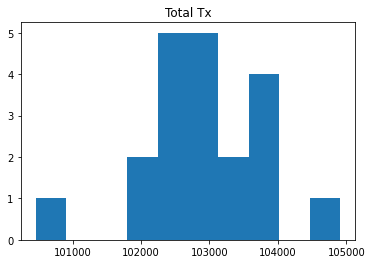

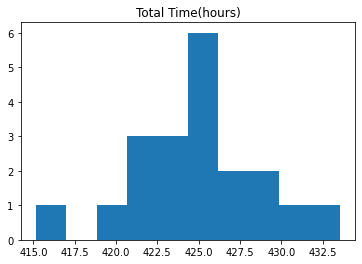

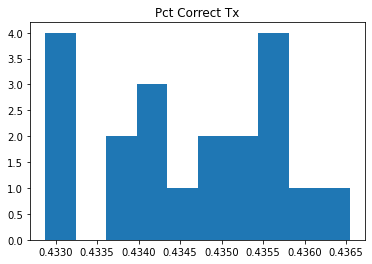

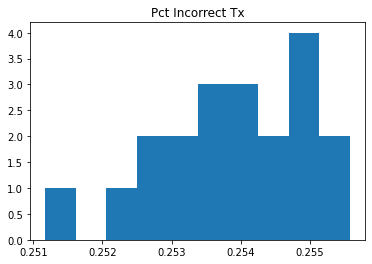

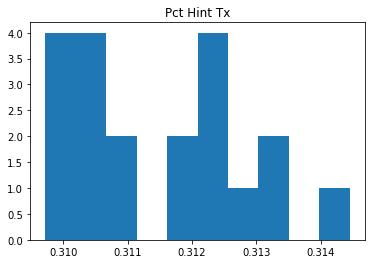

In [93]:
plt.hist(stu_stats['Total Tx'], bins=10)
plt.title("Total Tx")
plt.show()

plt.hist(stu_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.hist(stu_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")
plt.show()

plt.hist(stu_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")
plt.show()

plt.hist(stu_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

In [114]:
tx['kc'] = tx['kcs'].apply(lambda x: x[0]['_id'])
tx.head()

,_id,type,time,curric_id,unit_id,section_id,prob_id,step_id,stu_id,duration,outcome,kcs,plt,plt1,hints_used,hints_avail,attempt,kc
0,e2fd6c52-cb39-47dc-8a31-d575b162f136,Tutor Input,2020-09-24 16:39:37.111,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,13.105585,Incorrect,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.308845,0.228682,0,3,0,c276d48d-1a0f-4702-8020-067e49ef1018
1,0a99958b-1d02-4223-928e-f7bd3b7a3154,Tutor Input,2020-09-24 16:39:46.743,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,9.632849,Hint,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,0,3,1,c276d48d-1a0f-4702-8020-067e49ef1018
2,d8e0e63a-4fbf-4d0f-97f7-d08bcf52240a,Tutor Input,2020-09-24 16:39:56.339,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,9.595667,Hint,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,1,2,2,c276d48d-1a0f-4702-8020-067e49ef1018
3,59b8be24-971e-430f-83ea-d804628fbaeb,Tutor Input,2020-09-24 16:40:07.538,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,11.198586,Incorrect,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,2,1,3,c276d48d-1a0f-4702-8020-067e49ef1018
4,531d63f8-3fd0-4c16-8c84-2ddb7ca1ec01,Tutor Input,2020-09-24 16:49:41.571,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,7.130026,Incorrect,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,2,1,4,c276d48d-1a0f-4702-8020-067e49ef1018


In [111]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
prob_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id'])['duration'].count().reset_index()
section_stats = step_stats.groupby(['stu_id', 'unit_id', 'section_id'])['sum'].agg(['count', np.mean, np.std])
unit_stats = step_stats.groupby(['stu_id', 'unit_id'])['sum'].agg(['count', np.mean, np.std])
kc_stats = tx[['stu_id', 'kc', 'step_id']].unique().groupby(['stu_id', 'kc']).count()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]


KeyError: 'Column not found: duration'

In [119]:
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)

In [120]:
kc_stats = stu_kc_stats.groupby('kc').describe()

In [131]:
kc_stats.columns = [" ".join(col) for col in kc_stats.columns]
#["kc opportunities %s" % col for col in kc_stats.columns]

In [132]:
kc_stats.head()

,index,kc,kc opportunities count,kc opportunities mean,kc opportunities std,kc opportunities min,kc opportunities 25%,kc opportunities 50%,kc opportunities 75%,kc opportunities max
0,0,002d5af1-b78d-4d32-abed-00bbafc694c4,20.0,18.45,8.210872,5.0,13.00,19.5,24.00,30.0
1,1,002fd9ff-4d33-4def-83a6-53395dde2ef9,20.0,13.40,6.548604,3.0,8.50,13.5,18.50,23.0
2,2,0042e8b0-f16d-4773-9454-b230ec99aeb9,20.0,13.55,6.652859,5.0,7.75,13.5,18.00,25.0
3,3,005bd7eb-9703-408e-8992-6aba1ea9f010,20.0,15.35,6.823142,3.0,11.50,16.0,20.25,28.0
4,4,0064b3f0-516e-4c74-a19a-778a2dd66705,20.0,12.70,7.547045,3.0,7.00,10.5,17.25,30.0


In [63]:
print(stu_stats.index[0])
print(d.index[0])
print(stu_stats.index[0] == d.index[0])

014b3658-1d29-4e19-9ebb-c324344e8553
014b3658-1d29-4e19-9ebb-c324344e8553
True


In [57]:
tx['stu_id'] = tx['stu_id'].apply(str)
tx['_id'] = tx['_id'].apply(str)

In [58]:
type(tx['_id'][0])

str

In [52]:
tx.shape

(2058043, 17)

In [54]:
tx.head(20)

,_id,type,time,curric_id,unit_id,section_id,prob_id,step_id,stu_id,duration,outcome,kcs,plt,plt1,hints_used,hints_avail,attempt
0,e2fd6c52-cb39-47dc-8a31-d575b162f136,Tutor Input,2020-09-24 16:39:37.111,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,13.105585,Incorrect,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.308845,0.228682,0,3,0
1,0a99958b-1d02-4223-928e-f7bd3b7a3154,Tutor Input,2020-09-24 16:39:46.743,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,9.632849,Hint,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,0,3,1
2,d8e0e63a-4fbf-4d0f-97f7-d08bcf52240a,Tutor Input,2020-09-24 16:39:56.339,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,9.595667,Hint,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,1,2,2
3,59b8be24-971e-430f-83ea-d804628fbaeb,Tutor Input,2020-09-24 16:40:07.538,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,11.198586,Incorrect,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,2,1,3
4,531d63f8-3fd0-4c16-8c84-2ddb7ca1ec01,Tutor Input,2020-09-24 16:49:41.571,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,60798751-740e-4c07-9b6e-6b3e877b1a75,7.130026,Incorrect,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,2,1,4
5,NaN,Tutor Input,2020-09-24 16:49:49.199,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,1acb6606-6e94-459f-afea-fbe976bc8288,9612c254-26bf-49c4-a119-8a66f5bbfc76,nan,7.627862,Correct,"[{'_id': c276d48d-1a0f-4702-8020-067e49ef1018,...",0.228682,0.228682,2,1,5
6,NaN,Tutor Input,2020-09-24 16:49:55.954,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,0d0301c8-4b9c-4714-b739-0c4a7460d7ef,c7b938a9-53ee-4f63-b00c-04ec98e89002,nan,6.754996,Correct,"[{'_id': 1bda1bc0-d7ce-4f25-a965-caafb1fdb306,...",0.411251,0.708237,0,3,0
7,NaN,Tutor Input,2020-09-24 16:50:13.457,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,cbccc8b0-f485-4994-ba01-1d1083f7276f,f4b391b6-5518-4bb6-97cc-df5436363b7e,nan,17.503071,Hint,"[{'_id': a6b9d846-d3e2-49cd-88e8-349a2338c807,...",0.337540,0.219349,0,3,0
8,NaN,Tutor Input,2020-09-24 16:50:21.128,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,cbccc8b0-f485-4994-ba01-1d1083f7276f,f4b391b6-5518-4bb6-97cc-df5436363b7e,nan,7.670365,Hint,"[{'_id': a6b9d846-d3e2-49cd-88e8-349a2338c807,...",0.219349,0.219349,1,2,1
9,NaN,Tutor Input,2020-09-24 16:50:34.058,47c6857d-0d7c-44c5-b8dc-47057a25d71c,c0da64bc-ae59-4337-9127-26f312be0744,b529000b-34b3-40e8-a270-112939b5a08a,cbccc8b0-f485-4994-ba01-1d1083f7276f,f4b391b6-5518-4bb6-97cc-df5436363b7e,nan,12.930474,Hint,"[{'_id': a6b9d846-d3e2-49cd-88e8-349a2338c807,...",0.219349,0.219349,2,1,2
